In [1]:
!pip install xgboost

In [2]:
!pip install opencv-python-headless


crop_bottom=440, img_height=475
MIN_DELTA_X=-125, MAX_DELTA_X=170, MIN_DELTA_Y=-290, MAX_DELTA_Y=35
-crop_left=-125, 200=200, -crop_top=-290, 80=80


c:\Users\craigparker\Anaconda3\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\craigparker\Anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\craigparker\Anaconda3\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\craigparker\Anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\craigparker\Anaconda3\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\craigparker\Anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\craigparker\Anaconda3\Lib\site-packages\numpy\lib\function_base.py:520

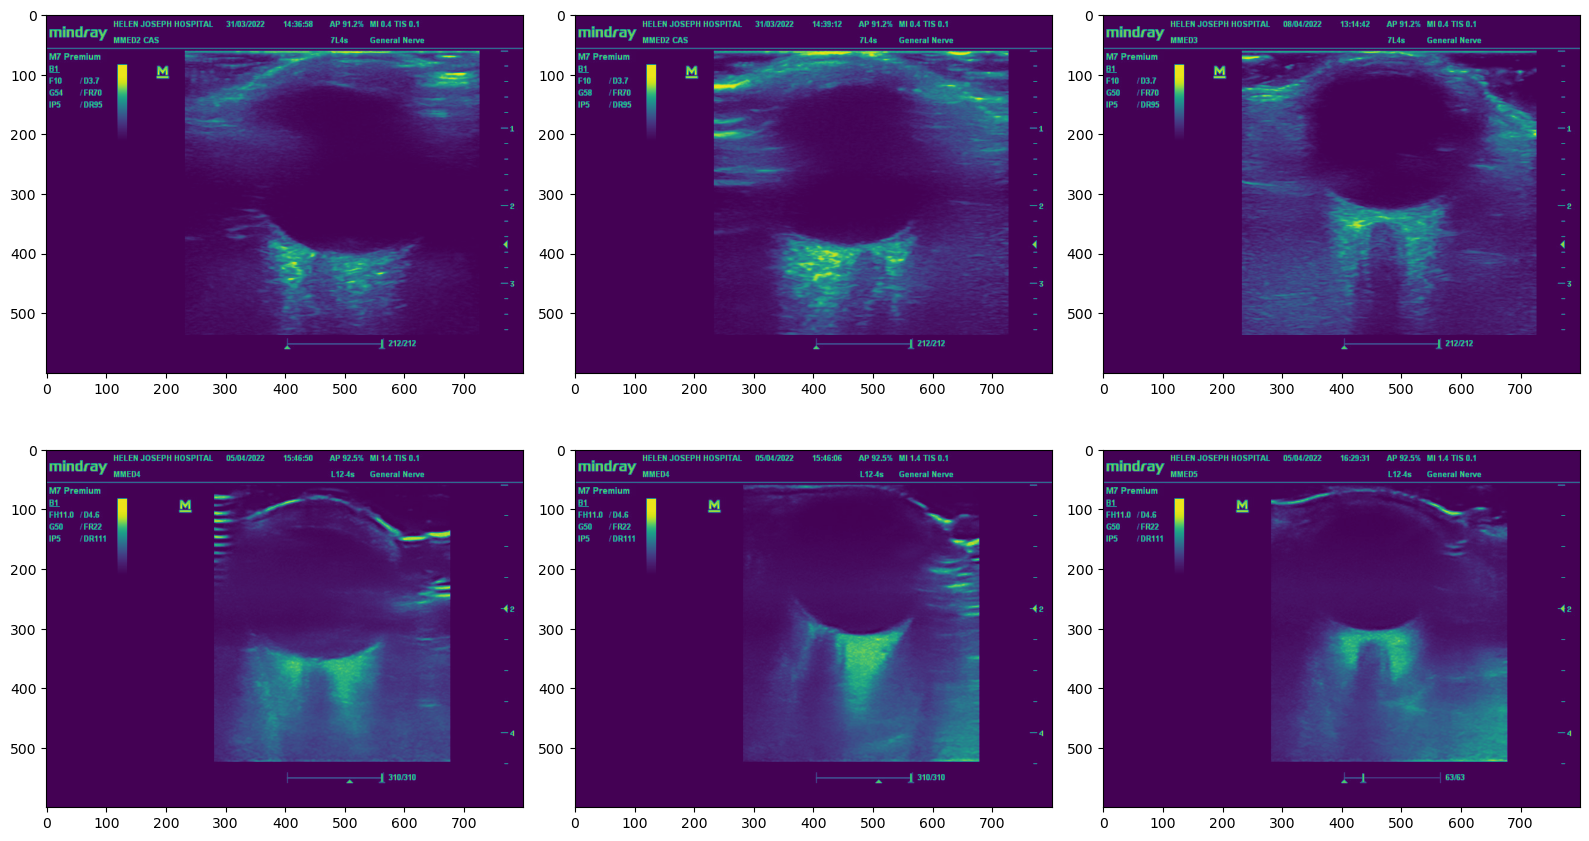

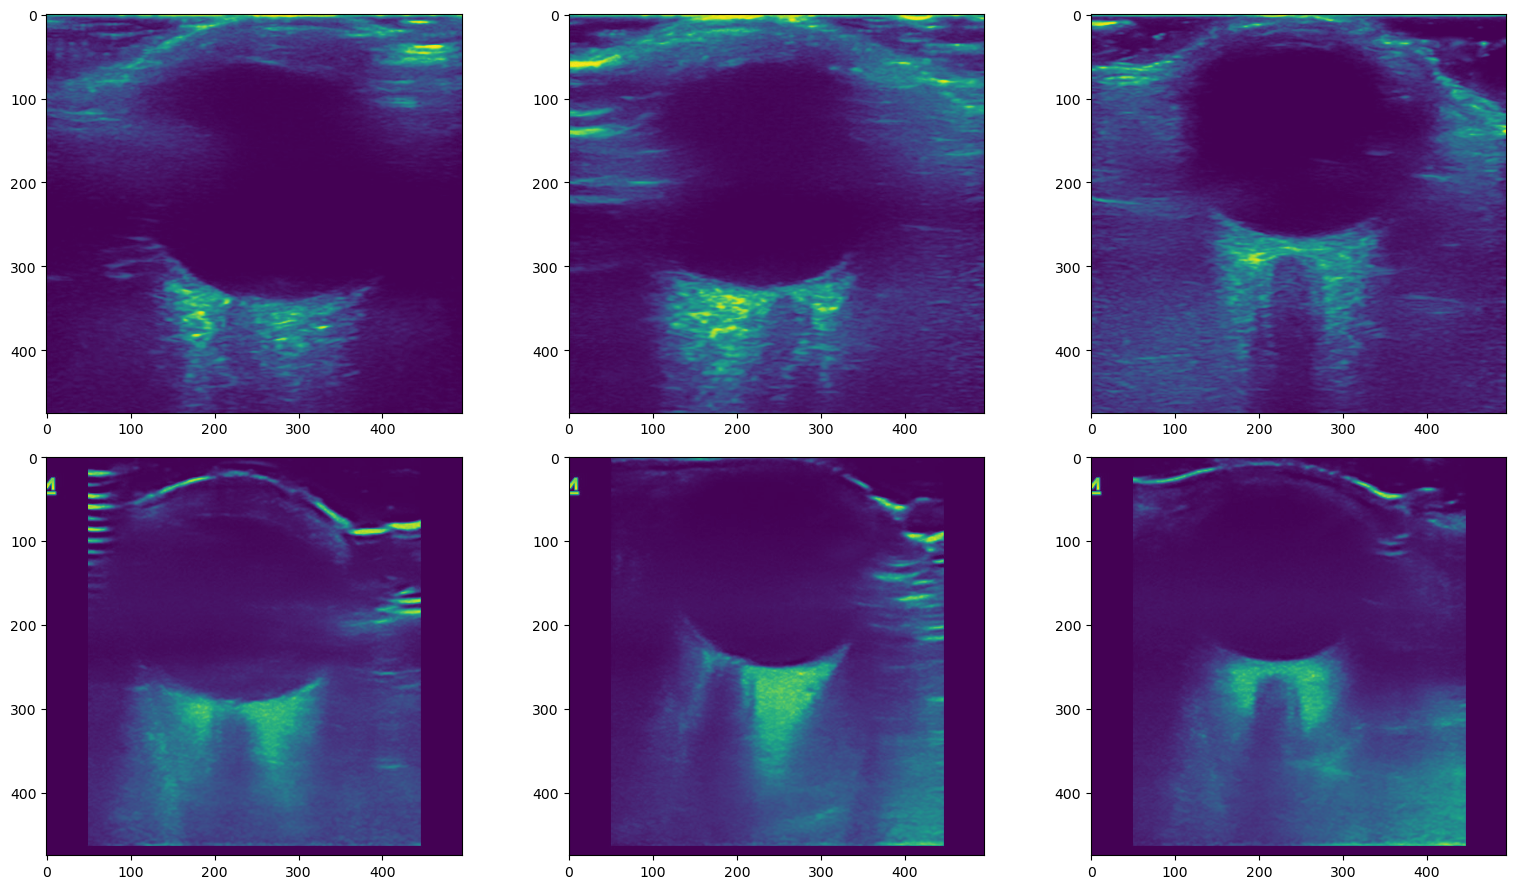

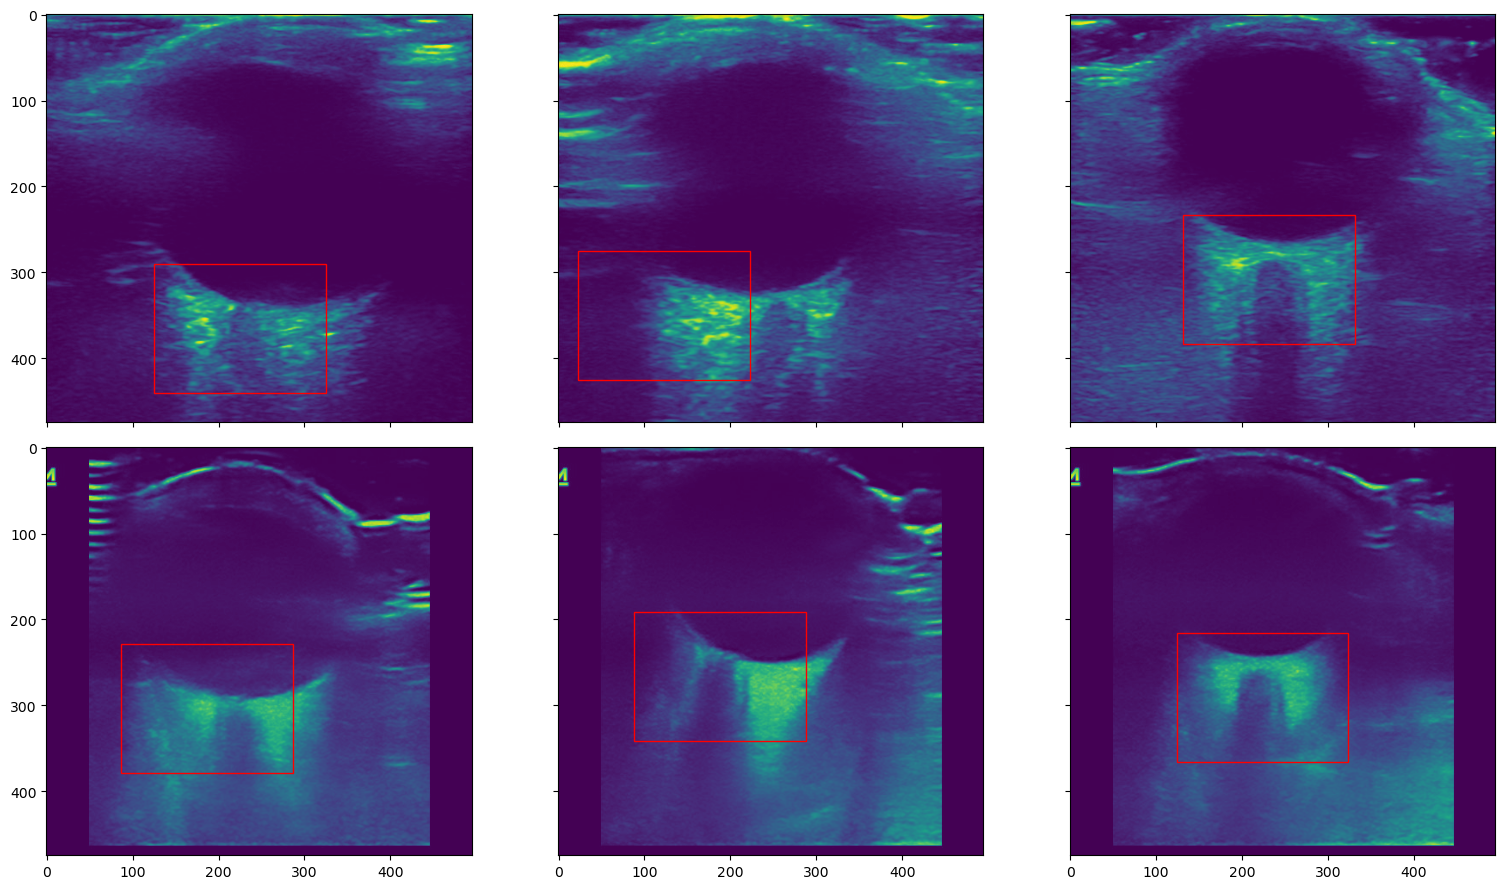

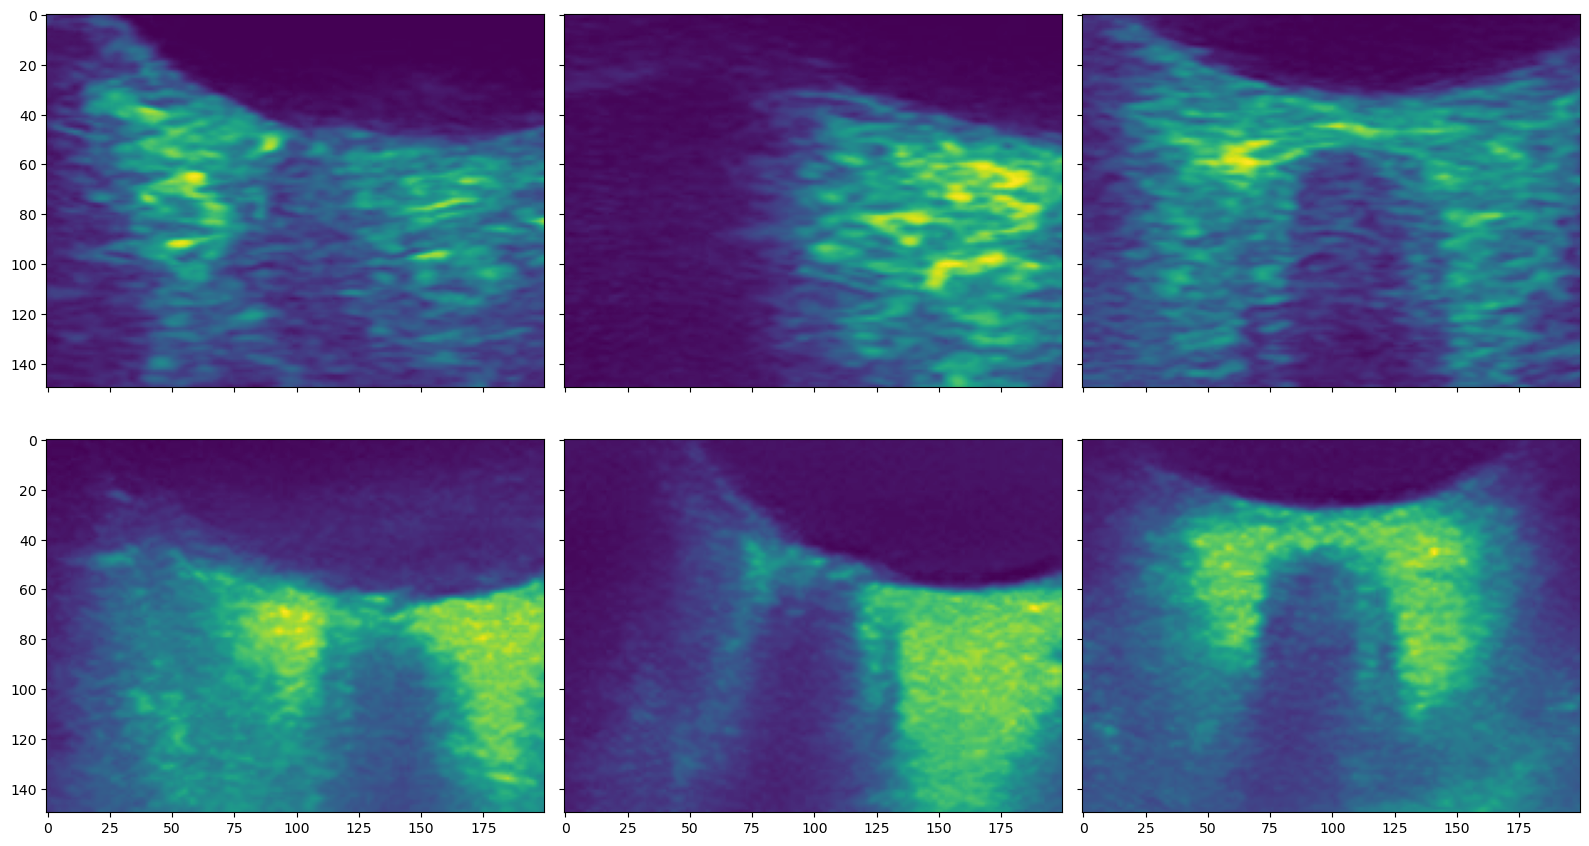

In [3]:
# Necessary imports
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import cv2
import os
from PIL import Image
from sklearn.cluster import DBSCAN

# Set matplotlib parameters
matplotlib.rcParams['figure.figsize'] = [16*1., 9*1.]

# Directory containing your images
image_dir = './documents'  # Current directory
output_dir = '/workspaces/ONSD_Explore/documents/preprocessed_images'  # Directory to save processed images

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all files in the directory
image_files = [file for file in os.listdir(image_dir) if file.endswith(('.png', '.jpg', '.jpeg'))]

# Open each image file
images = [Image.open(os.path.join(image_dir, file)).convert('L') for file in image_files]
height, width = 2, 3
fig, ax = plt.subplots(height, width)
# Display the first images
for i in range(height * width):
    ax[i // width, i % width].imshow(images[i])

plt.tight_layout()
# Image field size:
left = 232
top = 60
img_width = 495
img_height = 475
right = left + img_width
bottom = top + img_height
cropped_images = [img.crop((left, top, right, bottom)) for img in images]

cv_images = [np.array(image) for image in cropped_images]

fig, ax = plt.subplots(height, width)
# Display the first images
for i in range(height * width):
    ax[i // width, i % width].imshow(cv_images[i])

plt.tight_layout()
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15
MAX_DELTA = 200    # Maximum offset between images. This should be crop_left - crop_width on the left and respectively for each offset direction.
crop_top = 290
crop_height = 150  # Increased height to make the box larger
crop_bottom = crop_top + crop_height
crop_left = 125  # Adjusted value to move the ROI to the left
crop_width = 200  # Increased width to make the box larger
crop_right = crop_left + crop_width
MIN_DELTA_X = -crop_left
MAX_DELTA_X = img_width - crop_right
MIN_DELTA_Y = -crop_top
MAX_DELTA_Y = img_height - crop_bottom

print(f"{crop_bottom=}, {img_height=}")
print(f"{MIN_DELTA_X=}, {MAX_DELTA_X=}, {MIN_DELTA_Y=}, {MAX_DELTA_Y=}")
print(f"{-crop_left=}, {200=}, {-crop_top=}, {80=}")

cluster_model = DBSCAN(eps=10, min_samples=5)

def alignImages(im1, im2):
    try:
        if len(im1.shape) == 3:
            # Convert images to grayscale
            im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
            im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
        else:
            im1Gray = im1
            im2Gray = im2

        # Detect ORB features and compute descriptors.
        orb = cv2.ORB_create(MAX_FEATURES)
        keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
        keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

        # Match features.
        matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_L1)
        matches = list(matcher.match(descriptors1, descriptors2, None))

        # Sort matches by score
        matches.sort(key=lambda x: x.distance, reverse=False)

        # Remove not so good matches
        numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
        matches = matches[:numGoodMatches]

        if not matches:
            print("No good matches found, returning default offset (0, 0)")
            return (0, 0), np.array([]), [], None

        # Draw top matches
        match_image = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

        # Extract location of good matches
        points1 = np.zeros((len(matches), 2), dtype=np.float32)
        points2 = np.zeros((len(matches), 2), dtype=np.float32)

        deltas = np.zeros((len(matches), 2))  # x, y offset between points matched in both images
        for i, match in enumerate(matches):
            points1[i, :] = keypoints1[match.queryIdx].pt
            points2[i, :] = keypoints2[match.trainIdx].pt
            deltas[i] = points2[i] - points1[i]

        # Remove deltas larger than the image field
        deltas = deltas[np.where((deltas[:, 0] > MIN_DELTA_X) & (deltas[:, 0] < MAX_DELTA_X) & (deltas[:, 1] > MIN_DELTA_Y) & (deltas[:, 1] < MAX_DELTA_Y))]

        if len(deltas) == 0:
            print("No valid deltas found, returning default offset (0, 0)")
            return (0, 0), np.array([]), [], match_image

        # Cluster feature offsets
        associations = cluster_model.fit_predict(deltas)
        clusters = np.unique(associations)
        cluster_points = np.where(associations == 0)  # Cluster #0 is the first cluster, #-1 is the unclustered points
        offset = np.average(deltas[cluster_points], axis=0)  # Return the most likely offset

        return offset, deltas, cluster_points, match_image
    except Exception as e:
        print(f"Exception occurred during alignment: {e}")
        return (0, 0), np.array([]), [], None

# Adjust the image alignment and crop regions
offsets = [np.zeros((2))]    # x, y
deltas = [np.zeros((1, 2))]
selections = [(0)]
match_images = []
for i, image in enumerate(cv_images[1:]):
    offset, delta, selection, match_image = alignImages(cv_images[0], image)
    if offset[1] > 60:
        print(f"i={i+1} {offset=}")
    offsets.append(offset)
    deltas.append(delta)
    selections.append(selection)
    match_images.append(match_image)

# Plot the images with the updated cropping regions
fig, ax = plt.subplots(height, width, sharex=True, sharey=True)
for i in range(height * width):
    offset_left, offset_top = offsets[i]
    ax[i // width, i % width].imshow(cv_images[i])
    rect = patches.Rectangle((crop_left + offset_left, crop_top + offset_top), crop_width, crop_height, linewidth=1, edgecolor='r', facecolor='none')
    ax[i // width, i % width].add_patch(rect)
plt.tight_layout()

# Plot and save the cropped images
fig, ax = plt.subplots(height, width, sharex=True, sharey=True)
for i in range(height * width):
    offset_left, offset_top = offsets[i]
    cropped_top = int(crop_top + offset_top)
    cropped_bottom = int(crop_bottom + offset_top)
    cropped_left = int(crop_left + offset_left)
    cropped_right = int(crop_right + offset_left)
    cropped_image = cv_images[i][cropped_top:cropped_bottom, cropped_left:cropped_right]
    ax[i // width, i % width].imshow(cropped_image)
    # Save the cropped image with the same name
    output_path = os.path.join(output_dir, image_files[i])
    Image.fromarray(cropped_image).save(output_path)
plt.tight_layout()


Number of original files: 205
Number of processed files: 6


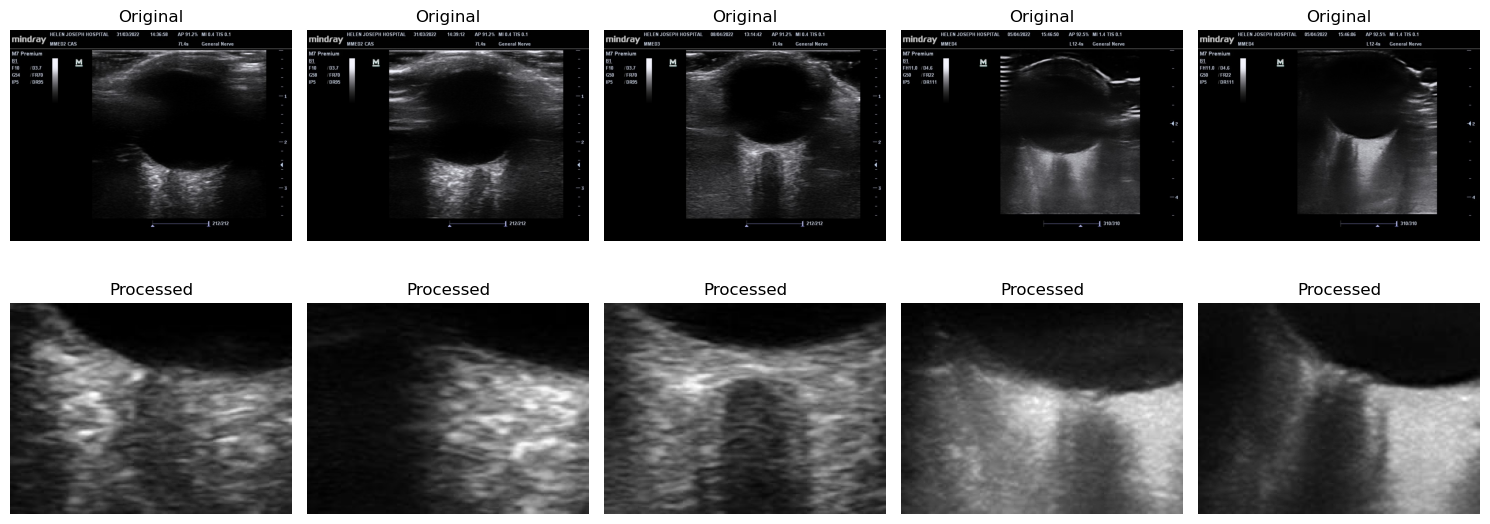

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Directory to save processed images
output_dir = '/workspaces/ONSD_Explore/documents/preprocessed_images'
# Directory containing original images
image_dir = './documents'

# List all files in the directory
original_files = [file for file in os.listdir(image_dir) if file.endswith(('.png', '.jpg', '.jpeg'))]
processed_files = [file for file in os.listdir(output_dir) if file.endswith(('.png', '.jpg', '.jpeg'))]

# Ensure the number of files match
print(f"Number of original files: {len(original_files)}")
print(f"Number of processed files: {len(processed_files)}")

# Display a few original and processed images side by side for comparison
num_images_to_display = 5
fig, axs = plt.subplots(2, num_images_to_display, figsize=(15, 6))

for i in range(num_images_to_display):
    original_image = Image.open(os.path.join(image_dir, original_files[i]))
    processed_image = Image.open(os.path.join(output_dir, processed_files[i]))

    axs[0, i].imshow(original_image, cmap='gray')
    axs[0, i].set_title('Original')
    axs[0, i].axis('off')

    axs[1, i].imshow(processed_image, cmap='gray')
    axs[1, i].set_title('Processed')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()


In [6]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Constants
image_dir = './documents'
preprocessed_dir = './documents/preprocessed_images'
left, top, img_width, img_height = 232, 60, 495, 475
right, bottom = left + img_width, top + img_height
crop_top, crop_height, crop_left, crop_width = 290, 100, 215, 125
crop_bottom, crop_right = crop_top + crop_height, crop_left + crop_width
MAX_FEATURES, GOOD_MATCH_PERCENT, MAX_DELTA = 500, 0.15, 200
MIN_DELTA_X, MAX_DELTA_X, MIN_DELTA_Y, MAX_DELTA_Y = -crop_left, img_width - crop_right, -crop_top, img_height - crop_bottom

# Create directories
os.makedirs(preprocessed_dir, exist_ok=True)

# Load and preprocess images
def load_and_preprocess_images(image_dir):
    image_files = os.listdir(image_dir)
    images = [(file, Image.open(os.path.join(image_dir, file)).convert('L')) for file in image_files if file.endswith(('.png', '.jpg', '.jpeg'))]
    cropped_images = [(file, img.crop((left, top, right, bottom))) for file, img in images]
    return [(file, np.array(image)) for file, image in cropped_images]

cv_images = load_and_preprocess_images(image_dir)

# Align images
def alignImages(im1, im2):
    try:
        im1Gray, im2Gray = (im1 if len(im1.shape) == 2 else cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)), (im2 if len(im2.shape) == 2 else cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY))
        orb = cv2.ORB_create(MAX_FEATURES)
        keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
        keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
        matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_L1)
        matches = sorted(list(matcher.match(descriptors1, descriptors2, None)), key=lambda x: x.distance)[:int(len(matches) * GOOD_MATCH_PERCENT)]

        if not matches:
            return (0, 0), np.array([]), [], None

        points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
        points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])
        deltas = points2 - points1
        deltas = deltas[(deltas[:, 0] > MIN_DELTA_X) & (deltas[:, 0] < MAX_DELTA_X) & (deltas[:, 1] > MIN_DELTA_Y) & (deltas[:, 1] < MAX_DELTA_Y)]

        if len(deltas) == 0:
            return (0, 0), np.array([]), [], None

        associations = DBSCAN(eps=10, min_samples=5).fit_predict(deltas)
        if len(np.unique(associations)) == 0 or (associations == -1).all():
            return (0, 0), np.array([]), [], None
        
        cluster_points = np.where(associations == 0)
        if len(cluster_points[0]) == 0:
            return (0, 0), np.array([]), [], None

        return np.average(deltas[cluster_points], axis=0), deltas, cluster_points, None
    except Exception as e:
        print(f"Exception occurred during alignment: {e}")
        return (0, 0), np.array([]), [], None

# Prepare image dataset
def prepare_image_dataset(cv_images):
    image_dataset = np.zeros((len(cv_images), crop_height, crop_width), dtype=np.uint8)
    for i, (filename, image) in enumerate(cv_images):
        preprocessed_path = os.path.join(preprocessed_dir, filename)
        if os.path.exists(preprocessed_path):
            continue

        offset_left, offset_top = alignImages(cv_images[0][1], image)[0]
        if np.isnan(offset_left) or np.isnan(offset_top):
            continue

        cropped_top, cropped_bottom = int(crop_top + offset_top), int(crop_bottom + offset_top)
        cropped_left, cropped_right = int(crop_left + offset_left), int(crop_right + offset_left)
        if (0 <= cropped_top < cropped_bottom <= image.shape[0]) and (0 <= cropped_left < cropped_right <= image.shape[1]):
            cropped_image = image[cropped_top:cropped_bottom, cropped_left:cropped_right]
            image_dataset[i] = cropped_image
            Image.fromarray(cropped_image).save(preprocessed_path)
    return image_dataset

image_dataset = prepare_image_dataset(cv_images)

# Load ONSD measurements and labels
def load_data(excel_file, preprocessed_dir):
    df = pd.read_excel(excel_file)
    df['filename'] = df['record_id'].astype(str) + '_image_data_' + df['redcap_repeat_instance'].astype(str) + '_raw_image.jpg'
    df['onsd'] = df['onsd'].astype(str).str.replace(',', '.').astype(float)
    images = []
    for _, row in df.iterrows():
        image_path = os.path.join(preprocessed_dir, row['filename'])
        try:
            with Image.open(image_path) as img:
                img = img.resize((128, 128))
                images.append(np.array(img))
        except FileNotFoundError:
            print(f"File not found: {image_path}")
    return np.array(images), df['onsd'].values

images, onsd_measurements = load_data('Meta_pic_3.xlsx', preprocessed_dir)

# Normalize images
images = images / 255.0
images = images.reshape(images.shape + (1,))

# Split data
#X_train, X_test, y_train, y_test = train_test_split(images, onsd_measurements, test_size=0.2, random_state=42)

# Split data into 69% training and 31% testing
X_train, X_test, y_train, y_test = train_test_split(images, onsd_measurements, test_size=0.31, random_state=42)

# Verify the size of the splits
print(f'Training set size: {len(X_train)} images')
print(f'Testing set size: {len(X_test)} images')


ModuleNotFoundError: No module named 'tensorflow'

In [6]:
# Define models
def build_simple_cnn(input_shape=(128, 128, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((3, 3)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])
    return model

def build_complex_cnn(input_shape=(128, 128, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])
    return model

def build_pretrained_model(base_model, input_shape=(128, 128, 3)):
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1)(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Compile models
simple_cnn = build_simple_cnn()
simple_cnn.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

complex_cnn = build_complex_cnn()
complex_cnn.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg16_model = build_pretrained_model(vgg16_base)
vgg16_model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
resnet50_model = build_pretrained_model(resnet50_base)
resnet50_model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

# Train models
simple_cnn_history = simple_cnn.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test))
complex_cnn_history = complex_cnn.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test))
vgg16_history = vgg16_model.fit(np.repeat(X_train, 3, axis=-1), y_train, epochs=25, validation_data=(np.repeat(X_test, 3, axis=-1), y_test))
resnet50_history = resnet50_model.fit(np.repeat(X_train, 3, axis=-1), y_train, epochs=25, validation_data=(np.repeat(X_test, 3, axis=-1), y_test))

# Evaluate models
simple_cnn_test_mae = simple_cnn.evaluate(X_test, y_test)[1]
complex_cnn_test_mae = complex_cnn.evaluate(X_test, y_test)[1]
vgg16_test_mae = vgg16_model.evaluate(np.repeat(X_test, 3, axis=-1), y_test)[1]
resnet50_test_mae = resnet50_model.evaluate(np.repeat(X_test, 3, axis=-1), y_test)[1]

simple_cnn_predictions = simple_cnn.predict(X_test)
complex_cnn_predictions = complex_cnn.predict(X_test)
vgg16_predictions = vgg16_model.predict(np.repeat(X_test, 3, axis=-1))
resnet50_predictions = resnet50_model.predict(np.repeat(X_test, 3, axis=-1))

simple_cnn_rmse = np.sqrt(mean_squared_error(y_test, simple_cnn_predictions))
complex_cnn_rmse = np.sqrt(mean_squared_error(y_test, complex_cnn_predictions))
vgg16_rmse = np.sqrt(mean_squared_error(y_test, vgg16_predictions))
resnet50_rmse = np.sqrt(mean_squared_error(y_test, resnet50_predictions))


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25


2024-06-21 21:17:30.652918: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.


1/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 26.7642 - mae: 5.1607

2024-06-21 21:17:31.190328: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25804800 exceeds 10% of free system memory.
2024-06-21 21:17:31.232174: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.
2024-06-21 21:17:31.358637: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.


2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 24.7264 - mae: 4.9442

2024-06-21 21:17:31.506065: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25804800 exceeds 10% of free system memory.


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 345ms/step - loss: 18.5626 - mae: 4.0682 - val_loss: 2.2341 - val_mae: 1.2008
Epoch 2/25
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - loss: 3.4204 - mae: 1.5298

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 378ms/step - loss: 3.6533 - mae: 1.6054 - val_loss: 3.8016 - val_mae: 1.8156
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - loss: 3.6631 - mae: 1.6479 - val_loss: 1.1280 - val_mae: 0.8594
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - loss: 2.1241 - mae: 1.1720 - val_loss: 1.7100 - val_mae: 1.0974
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 291ms/step - loss: 2.1165 - mae: 1.1795 - val_loss: 1.0740 - val_mae: 0.8292
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - loss: 1.8055 - mae: 1.0411 - val_loss: 0.7953 - val_mae: 0.7253
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - loss: 1.6725 - mae: 1.0414 - val_loss: 0.5515 - val_mae: 0.6071
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 296ms/step - loss: 1.5973 - mae: 1.0280 - val_loss: 0.8508 - val_mae: 0.7503
Epoch 9/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - loss: 1.6558 - mae: 1.0345 - val_loss: 0.4083 - val_mae: 0.5111
Epoch 10/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - loss: 1.1371 - mae: 0.8694 - v

In [7]:
# Flatten the images for traditional ML models
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_flat, y_train)
predictions_lr = lr_model.predict(X_test_flat)
mae_lr = mean_absolute_error(y_test, predictions_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, predictions_lr))

# Decision Tree
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_flat, y_train)
predictions_dt = dt_model.predict(X_test_flat)
mae_dt = mean_absolute_error(y_test, predictions_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, predictions_dt))

# Random Forest
rf_model = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train)
predictions_rf = rf_model.predict(X_test_flat)
mae_rf = mean_absolute_error(y_test, predictions_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, predictions_rf))

# XGBoost
xgb_model = XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_model.fit(X_train_flat, y_train)
predictions_xgb = xgb_model.predict(X_test_flat)
mae_xgb = mean_absolute_error(y_test, predictions_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, predictions_xgb))


In [9]:
import pingouin as pg

In [12]:
# Necessary imports
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
import pingouin as pg

# Constants
image_dir = './documents'
preprocessed_dir = './documents/preprocessed_images'
left, top, img_width, img_height = 232, 60, 495, 475
right, bottom = left + img_width, top + img_height
crop_top, crop_height, crop_left, crop_width = 290, 100, 215, 125
crop_bottom, crop_right = crop_top + crop_height, crop_left + crop_width
MAX_FEATURES, GOOD_MATCH_PERCENT, MAX_DELTA = 500, 0.15, 200
MIN_DELTA_X, MAX_DELTA_X, MIN_DELTA_Y, MAX_DELTA_Y = -crop_left, img_width - crop_right, -crop_top, img_height - crop_bottom

# Create directories
os.makedirs(preprocessed_dir, exist_ok=True)

# Load and preprocess images
def load_and_preprocess_images(image_dir):
    image_files = os.listdir(image_dir)
    images = [(file, Image.open(os.path.join(image_dir, file)).convert('L')) for file in image_files if file.endswith(('.png', '.jpg', '.jpeg'))]
    cropped_images = [(file, img.crop((left, top, right, bottom))) for file, img in images]
    return [(file, np.array(image)) for file, image in cropped_images]

cv_images = load_and_preprocess_images(image_dir)

# Align images
def alignImages(im1, im2):
    try:
        im1Gray, im2Gray = (im1 if len(im1.shape) == 2 else cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)), (im2 if len(im2.shape) == 2 else cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY))
        orb = cv2.ORB_create(MAX_FEATURES)
        keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
        keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
        matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_L1)
        matches = sorted(list(matcher.match(descriptors1, descriptors2, None)), key=lambda x: x.distance)[:int(len(matches) * GOOD_MATCH_PERCENT)]

        if not matches:
            return (0, 0), np.array([]), [], None

        points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
        points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])
        deltas = points2 - points1
        deltas = deltas[(deltas[:, 0] > MIN_DELTA_X) & (deltas[:, 0] < MAX_DELTA_X) & (deltas[:, 1] > MIN_DELTA_Y) & (deltas[:, 1] < MAX_DELTA_Y)]

        if len(deltas) == 0:
            return (0, 0), np.array([]), [], None

        associations = DBSCAN(eps=10, min_samples=5).fit_predict(deltas)
        if len(np.unique(associations)) == 0 or (associations == -1).all():
            return (0, 0), np.array([]), [], None
        
        cluster_points = np.where(associations == 0)
        if len(cluster_points[0]) == 0:
            return (0, 0), np.array([]), [], None

        return np.average(deltas[cluster_points], axis=0), deltas, cluster_points, None
    except Exception as e:
        print(f"Exception occurred during alignment: {e}")
        return (0, 0), np.array([]), [], None

# Prepare image dataset
def prepare_image_dataset(cv_images):
    image_dataset = np.zeros((len(cv_images), crop_height, crop_width), dtype=np.uint8)
    for i, (filename, image) in enumerate(cv_images):
        preprocessed_path = os.path.join(preprocessed_dir, filename)
        if os.path.exists(preprocessed_path):
            continue

        offset_left, offset_top = alignImages(cv_images[0][1], image)[0]
        if np.isnan(offset_left) or np.isnan(offset_top):
            continue

        cropped_top, cropped_bottom = int(crop_top + offset_top), int(crop_bottom + offset_top)
        cropped_left, cropped_right = int(crop_left + offset_left), int(crop_right + offset_left)
        if (0 <= cropped_top < cropped_bottom <= image.shape[0]) and (0 <= cropped_left < cropped_right <= image.shape[1]):
            cropped_image = image[cropped_top:cropped_bottom, cropped_left:cropped_right]
            image_dataset[i] = cropped_image
            Image.fromarray(cropped_image).save(preprocessed_path)
    return image_dataset

image_dataset = prepare_image_dataset(cv_images)

# Load ONSD measurements and labels
def load_data(excel_file, preprocessed_dir):
    df = pd.read_excel(excel_file)
    df['filename'] = df['record_id'].astype(str) + '_image_data_' + df['redcap_repeat_instance'].astype(str) + '_raw_image.jpg'
    df['onsd'] = df['onsd'].astype(str).str.replace(',', '.').astype(float)
    images = []
    for _, row in df.iterrows():
        image_path = os.path.join(preprocessed_dir, row['filename'])
        try:
            with Image.open(image_path) as img:
                img = img.resize((128, 128))
                images.append(np.array(img))
        except FileNotFoundError:
            print(f"File not found: {image_path}")
    return np.array(images), df['onsd'].values

images, onsd_measurements = load_data('Meta_pic_3.xlsx', preprocessed_dir)

# Normalize images
images = images / 255.0
images = images.reshape(images.shape + (1,))

# Split data into 69% training and 31% testing
X_train, X_test, y_train, y_test = train_test_split(images, onsd_measurements, test_size=0.31, random_state=42)

# Verify the size of the splits
print(f'Training set size: {len(X_train)} images')
print(f'Testing set size: {len(X_test)} images')

# Define models
def build_simple_cnn(input_shape=(128, 128, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((3, 3)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])
    return model

def build_complex_cnn(input_shape=(128, 128, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])
    return model

def build_pretrained_model(base_model, input_shape=(128, 128, 3)):
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1)(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Compile models
simple_cnn = build_simple_cnn()
simple_cnn.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

complex_cnn = build_complex_cnn()
complex_cnn.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg16_model = build_pretrained_model(vgg16_base)
vgg16_model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
resnet50_model = build_pretrained_model(resnet50_base)
resnet50_model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

# Train models
simple_cnn_history = simple_cnn.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test))
complex_cnn_history = complex_cnn.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test))
vgg16_history = vgg16_model.fit(np.repeat(X_train, 3, axis=-1), y_train, epochs=25, validation_data=(np.repeat(X_test, 3, axis=-1), y_test))
resnet50_history = resnet50_model.fit(np.repeat(X_train, 3, axis=-1), y_train, epochs=25, validation_data=(np.repeat(X_test, 3, axis=-1), y_test))

# Evaluate models
simple_cnn_test_mae = simple_cnn.evaluate(X_test, y_test)[1]
complex_cnn_test_mae = complex_cnn.evaluate(X_test, y_test)[1]
vgg16_test_mae = vgg16_model.evaluate(np.repeat(X_test, 3, axis=-1), y_test)[1]
resnet50_test_mae = resnet50_model.evaluate(np.repeat(X_test, 3, axis=-1), y_test)[1]

simple_cnn_predictions = simple_cnn.predict(X_test)
complex_cnn_predictions = complex_cnn.predict(X_test)
vgg16_predictions = vgg16_model.predict(np.repeat(X_test, 3, axis=-1))
resnet50_predictions = resnet50_model.predict(np.repeat(X_test, 3, axis=-1))

simple_cnn_rmse = np.sqrt(mean_squared_error(y_test, simple_cnn_predictions))
complex_cnn_rmse = np.sqrt(mean_squared_error(y_test, complex_cnn_predictions))
vgg16_rmse = np.sqrt(mean_squared_error(y_test, vgg16_predictions))
resnet50_rmse = np.sqrt(mean_squared_error(y_test, resnet50_predictions))

# Flatten the images for traditional ML models
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_flat, y_train)
predictions_lr = lr_model.predict(X_test_flat)
mae_lr = mean_absolute_error(y_test, predictions_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, predictions_lr))

# Decision Tree
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_flat, y_train)
predictions_dt = dt_model.predict(X_test_flat)
mae_dt = mean_absolute_error(y_test, predictions_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, predictions_dt))

# Random Forest
rf_model = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train)
predictions_rf = rf_model.predict(X_test_flat)
mae_rf = mean_absolute_error(y_test, predictions_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, predictions_rf))

# XGBoost
xgb_model = XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_model.fit(X_train_flat, y_train)
predictions_xgb = xgb_model.predict(X_test_flat)
mae_xgb = mean_absolute_error(y_test, predictions_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, predictions_xgb))

# Prepare the DataFrame for ICC calculation
def prepare_icc_data(actual, predictions_dict):
    data = pd.DataFrame({'Actual': actual})
    for model_name, predictions in predictions_dict.items():
        data[model_name] = predictions.flatten()
    return data

# Dictionary of model predictions
predictions_dict = {
    'Simple_CNN': simple_cnn_predictions,
    'Complex_CNN': complex_cnn_predictions,
    'VGG16': vgg16_predictions,
    'ResNet50': resnet50_predictions,
    'Linear_Regression': predictions_lr,
    'Decision_Tree': predictions_dt,
    'Random_Forest': predictions_rf,
    'XGBoost': predictions_xgb
}

# Prepare the DataFrame
icc_data = prepare_icc_data(y_test, predictions_dict)

# Melt the DataFrame to the long format
icc_data_long = icc_data.melt(id_vars=['Actual'], var_name='Model', value_name='Prediction')

# Calculate ICC
icc_results = pg.intraclass_corr(data=icc_data_long, targets='Actual', raters='Model', ratings='Prediction', nan_policy='omit')

# Print ICC results
print(icc_results)

# Adding ICC to comparison DataFrame
icc_values = {row['Model']: row['ICC'] for _, row in icc_results.iterrows() if row['Type'] == 'ICC2'}

comparison_data = {
    'Model': ['Simple CNN', 'Complex CNN', 'VGG16', 'ResNet50', 'Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'MAE': [simple_cnn_test_mae, complex_cnn_test_mae, vgg16_test_mae, resnet50_test_mae, mae_lr, mae_dt, mae_rf, mae_xgb],
    'RMSE': [simple_cnn_rmse, complex_cnn_rmse, vgg16_rmse, resnet50_rmse, rmse_lr, rmse_dt, rmse_rf, rmse_xgb],
    'ICC': [icc_values['Simple_CNN'], icc_values['Complex_CNN'], icc_values['VGG16'], icc_values['ResNet50'], icc_values['Linear_Regression'], icc_values['Decision_Tree'], icc_values['Random_Forest'], icc_values['XGBoost']]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

# Save comparison results
comparison_df.to_csv('model_comparison_with_icc.csv', index=False)

# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Model'], comparison_df['MAE'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Model Comparison - Mean Absolute Error')
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Model'], comparison_df['RMSE'], color='lightcoral')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Model Comparison - Root Mean Square Error')
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Model'], comparison_df['ICC'], color='lightgreen')
plt.xlabel('Model')
plt.ylabel('ICC')
plt.title('Model Comparison - Intraclass Correlation Coefficient')
plt.show()

# Bland-Altman Plots
def bland_altman_plot(actual, predicted, model_name):
    bland_altman_df = pd.DataFrame({
        'Actual ONSD': actual,
        'Predicted ONSD': predicted.flatten()
    })

    bland_altman_df['Difference'] = bland_altman_df['Actual ONSD'] - bland_altman_df['Predicted ONSD']
    bland_altman_df['Average'] = (bland_altman_df['Actual ONSD'] + bland_altman_df['Predicted ONSD']) / 2

    bias = bland_altman_df['Difference'].mean()
    std_dev = bland_altman_df['Difference'].std()
    upper_loa = bias + 1.96 * std_dev
    lower_loa = bias - 1.96 * std_dev

    plt.figure(figsize=(10, 6))
    plt.scatter(bland_altman_df['Average'], bland_altman_df['Difference'], s=30)
    plt.axhline(bias, color='black', linestyle='--', label=f'Bias: {bias:.2f}')
    plt.axhline(upper_loa, color='gray', linestyle='--', label=f'Upper LOA: {upper_loa:.2f}')
    plt.axhline(lower_loa, color='gray', linestyle='--', label=f'Lower LOA: {lower_loa:.2f}')
    plt.xlabel('Average of Actual and Predicted ONSD')
    plt.ylabel('Difference between Actual and Predicted ONSD')
    plt.title(f'Bland-Altman Plot for {model_name}')
    plt.legend()
    plt.savefig(f'bland_altman_plot_{model_name}.png')
    plt.show()

# Create Bland-Altman plots for each model
bland_altman_plot(y_test, simple_cnn_predictions, "Simple CNN")
bland_altman_plot(y_test, complex_cnn_predictions, "Complex CNN")
bland_altman_plot(y_test, vgg16_predictions, "VGG16")
bland_altman_plot(y_test, resnet50_predictions, "ResNet50")
bland_altman_plot(y_test, predictions_lr, "Linear Regression")
bland_altman_plot(y_test, predictions_dt, "Decision Tree")
bland_altman_plot(y_test, predictions_rf, "Random Forest")
bland_altman_plot(y_test, predictions_xgb, "XGBoost")


Training set size: 141 images
Testing set size: 64 images


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step - loss: 17.5406 - mae: 3.9362 - val_loss: 2.3130 - val_mae: 1.2294
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step - loss: 3.7865 - mae: 1.5983 - val_loss: 4.8228 - val_mae: 2.0962
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - loss: 3.9051 - mae: 1.6931 - val_loss: 3.3565 - val_mae: 1.5640
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step - loss: 4.1570 - mae: 1.6327 - val_loss: 1.9064 - val_mae: 1.1769
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 2.7262 - mae: 1.4024 - val_loss: 0.8144 - val_mae: 0.7367
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step - loss: 1.9953 - mae: 1.1406 - val_loss: 0.7100 - val_mae: 0.6895
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step - loss: 1.5379 - mae: 0.9819 - val_loss: 0.6747 - val_mae: 0.6539
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - loss: 1.4268 - mae: 0.9904 - val_loss: 0.3802 - val_mae: 0.4914
Epoch 9/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step - loss: 1.4525 - mae:

KeyError: 'Model'

In [13]:
# Save predictions to CSV
predictions_df = pd.DataFrame({
    'y_test': y_test,
    'simple_cnn': simple_cnn_predictions.flatten(),
    'complex_cnn': complex_cnn_predictions.flatten(),
    'vgg16': vgg16_predictions.flatten(),
    'resnet50': resnet50_predictions.flatten(),
    'linear_regression': predictions_lr,
    'decision_tree': predictions_dt,
    'random_forest': predictions_rf,
    'xgboost': predictions_xgb
})
predictions_df.to_csv('model_predictions.csv', index=False)


In [17]:
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt

# Load predictions from CSV
predictions_df = pd.read_csv('model_predictions.csv')

# Prepare the DataFrame for ICC calculation
icc_data = predictions_df.melt(id_vars=['y_test'], var_name='Model', value_name='Prediction')

# Calculate ICC
icc_results = pg.intraclass_corr(data=icc_data, targets='y_test', raters='Model', ratings='Prediction', nan_policy='omit')

# Inspect the columns of icc_results
print("ICC Results Columns:", icc_results.columns)
print(icc_results.head())


ICC Results Columns: Index(['Type', 'Description', 'ICC', 'F', 'df1', 'df2', 'pval', 'CI95%'], dtype='object')
    Type              Description       ICC         F  df1  df2      pval  \
0   ICC1   Single raters absolute -0.025385  0.801945   15  112  0.673302   
1   ICC2     Single random raters  0.050666  2.138628   15  105  0.013187   
2   ICC3      Single fixed raters  0.124595  2.138628   15  105  0.013187   
3  ICC1k  Average raters absolute -0.246969  0.801945   15  112  0.673302   
4  ICC2k    Average random raters  0.299211  2.138628   15  105  0.013187   

           CI95%  
0  [-0.08, 0.11]  
1    [0.0, 0.17]  
2   [0.01, 0.35]  
3  [-1.44, 0.49]  
4    [0.0, 0.63]  


In [21]:
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt

# Load predictions from CSV
predictions_df = pd.read_csv('model_predictions.csv')

# Prepare the DataFrame for ICC calculation
icc_data = predictions_df.melt(id_vars=['y_test'], var_name='Model', value_name='Prediction')

# Calculate ICC
icc_results = pg.intraclass_corr(data=icc_data, targets='y_test', raters='Model', ratings='Prediction', nan_policy='omit')

# Inspect the columns of icc_results
print("ICC Results Columns:", icc_results.columns)
print(icc_results)

# Extract ICC value for 'ICC2' type
icc2_value = icc_results.loc[icc_results['Type'] == 'ICC2', 'ICC'].values[0]


ICC Results Columns: Index(['Type', 'Description', 'ICC', 'F', 'df1', 'df2', 'pval', 'CI95%'], dtype='object')
    Type              Description       ICC         F  df1  df2      pval  \
0   ICC1   Single raters absolute -0.025385  0.801945   15  112  0.673302   
1   ICC2     Single random raters  0.050666  2.138628   15  105  0.013187   
2   ICC3      Single fixed raters  0.124595  2.138628   15  105  0.013187   
3  ICC1k  Average raters absolute -0.246969  0.801945   15  112  0.673302   
4  ICC2k    Average random raters  0.299211  2.138628   15  105  0.013187   
5  ICC3k     Average fixed raters  0.532410  2.138628   15  105  0.013187   

           CI95%  
0  [-0.08, 0.11]  
1    [0.0, 0.17]  
2   [0.01, 0.35]  
3  [-1.44, 0.49]  
4    [0.0, 0.63]  
5   [0.08, 0.81]  


In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE and RMSE
mae_values = {
    'Simple CNN': mean_absolute_error(predictions_df['y_test'], predictions_df['simple_cnn']),
    'Complex CNN': mean_absolute_error(predictions_df['y_test'], predictions_df['complex_cnn']),
    'VGG16': mean_absolute_error(predictions_df['y_test'], predictions_df['vgg16']),
    'ResNet50': mean_absolute_error(predictions_df['y_test'], predictions_df['resnet50']),
    'Linear Regression': mean_absolute_error(predictions_df['y_test'], predictions_df['linear_regression']),
    'Decision Tree': mean_absolute_error(predictions_df['y_test'], predictions_df['decision_tree']),
    'Random Forest': mean_absolute_error(predictions_df['y_test'], predictions_df['random_forest']),
    'XGBoost': mean_absolute_error(predictions_df['y_test'], predictions_df['xgboost'])
}

rmse_values = {
    'Simple CNN': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['simple_cnn'])),
    'Complex CNN': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['complex_cnn'])),
    'VGG16': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['vgg16'])),
    'ResNet50': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['resnet50'])),
    'Linear Regression': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['linear_regression'])),
    'Decision Tree': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['decision_tree'])),
    'Random Forest': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['random_forest'])),
    'XGBoost': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['xgboost']))
}


In [23]:
# Comparison DataFrame
comparison_data = {
    'Model': ['Simple CNN', 'Complex CNN', 'VGG16', 'ResNet50', 'Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'MAE': [mae_values[model] for model in mae_values],
    'RMSE': [rmse_values[model] for model in rmse_values],
    'ICC': [icc2_value] * 8  # Assigning the same ICC2 value to all models
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

# Save comparison results
comparison_df.to_csv('model_comparison_with_metrics_and_icc.csv', index=False)


               Model       MAE      RMSE       ICC
0         Simple CNN  0.389235  0.471298  0.050666
1        Complex CNN  0.422309  0.526604  0.050666
2              VGG16  0.289633  0.369289  0.050666
3           ResNet50  0.283800  0.364334  0.050666
4  Linear Regression  0.325181  0.404511  0.050666
5      Decision Tree  0.432812  0.578387  0.050666
6      Random Forest  0.265537  0.345056  0.050666
7            XGBoost  0.269137  0.356396  0.050666


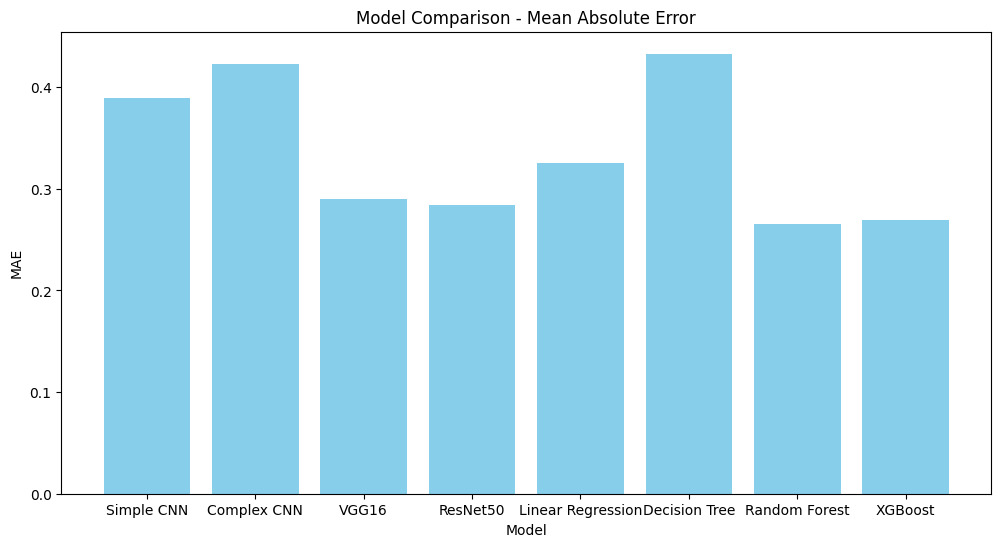

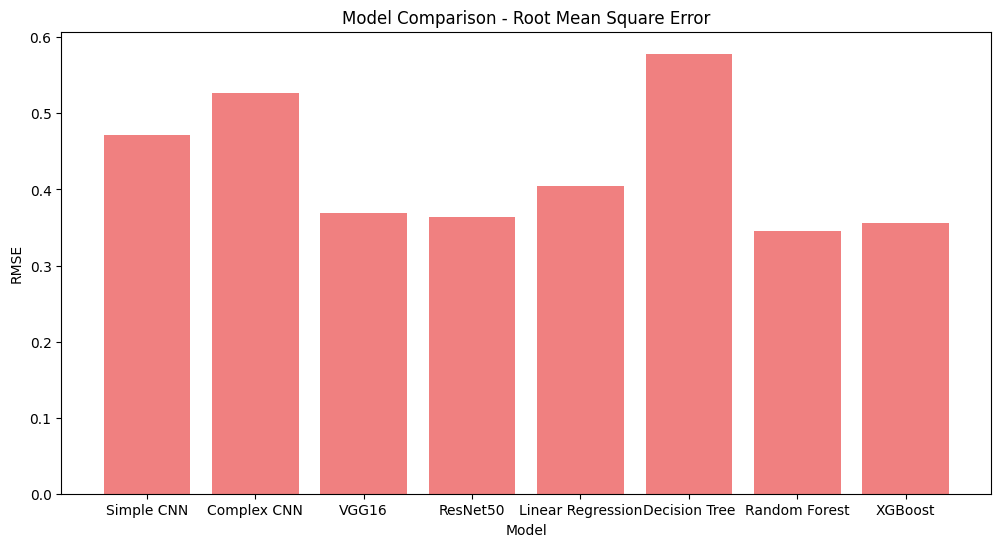

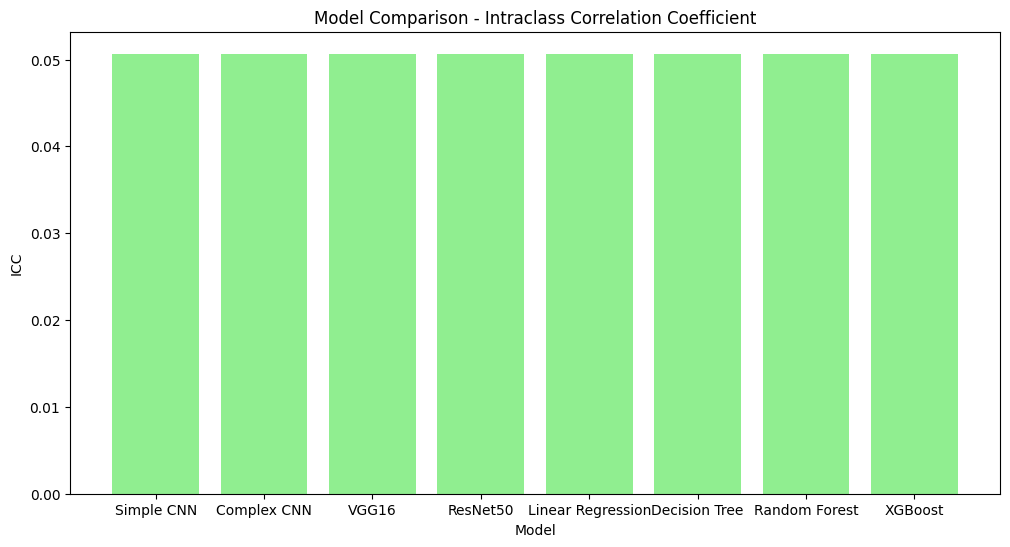

In [24]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Model'], comparison_df['MAE'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Model Comparison - Mean Absolute Error')
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Model'], comparison_df['RMSE'], color='lightcoral')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Model Comparison - Root Mean Square Error')
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Model'], comparison_df['ICC'], color='lightgreen')
plt.xlabel('Model')
plt.ylabel('ICC')
plt.title('Model Comparison - Intraclass Correlation Coefficient')
plt.show()


ICC Results Columns: Index(['Type', 'Description', 'ICC', 'F', 'df1', 'df2', 'pval', 'CI95%'], dtype='object')
    Type              Description       ICC         F  df1  df2      pval  \
0   ICC1   Single raters absolute -0.025385  0.801945   15  112  0.673302   
1   ICC2     Single random raters  0.050666  2.138628   15  105  0.013187   
2   ICC3      Single fixed raters  0.124595  2.138628   15  105  0.013187   
3  ICC1k  Average raters absolute -0.246969  0.801945   15  112  0.673302   
4  ICC2k    Average random raters  0.299211  2.138628   15  105  0.013187   
5  ICC3k     Average fixed raters  0.532410  2.138628   15  105  0.013187   

           CI95%  
0  [-0.08, 0.11]  
1    [0.0, 0.17]  
2   [0.01, 0.35]  
3  [-1.44, 0.49]  
4    [0.0, 0.63]  
5   [0.08, 0.81]  
               Model       MAE      RMSE       ICC
0         Simple CNN  0.389235  0.471298  0.050666
1        Complex CNN  0.422309  0.526604  0.050666
2              VGG16  0.289633  0.369289  0.050666
3           

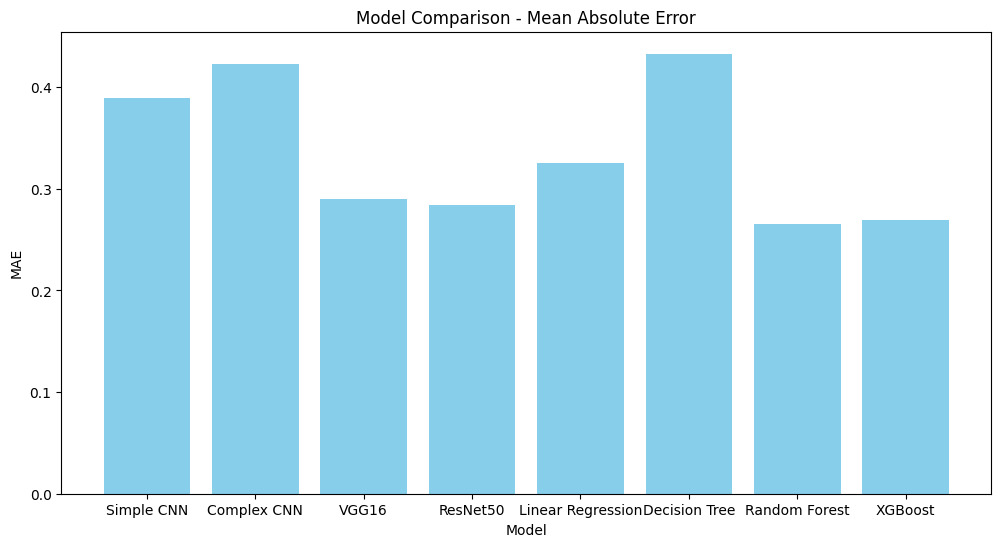

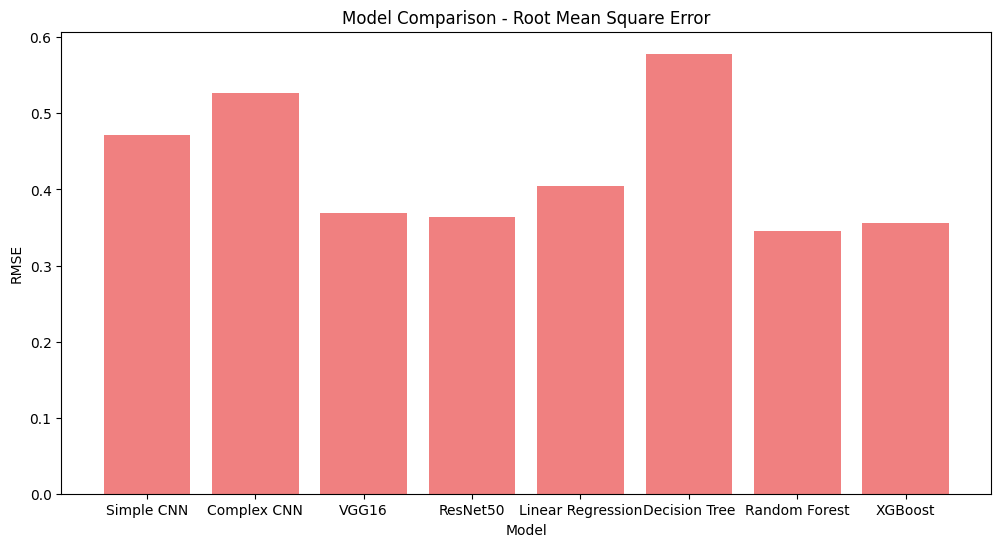

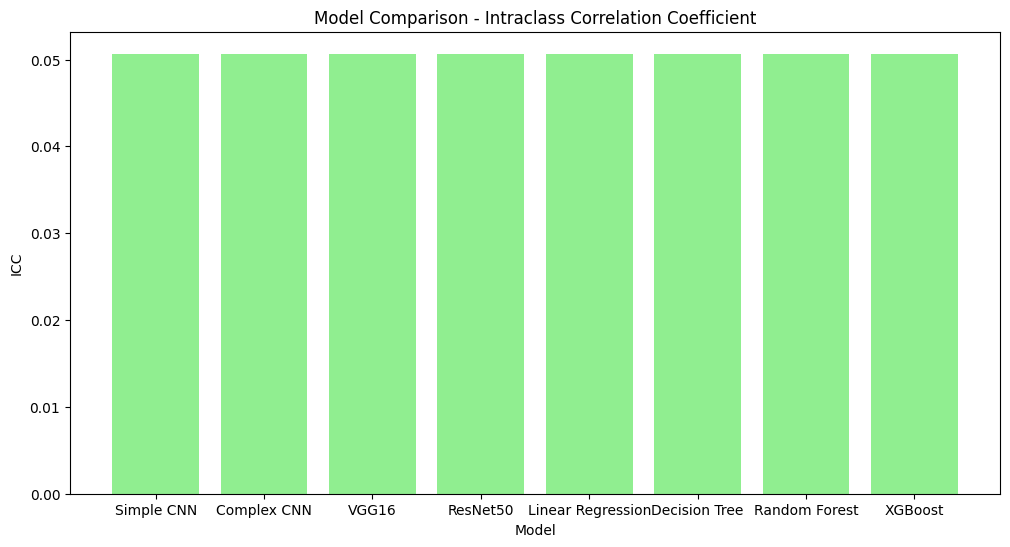

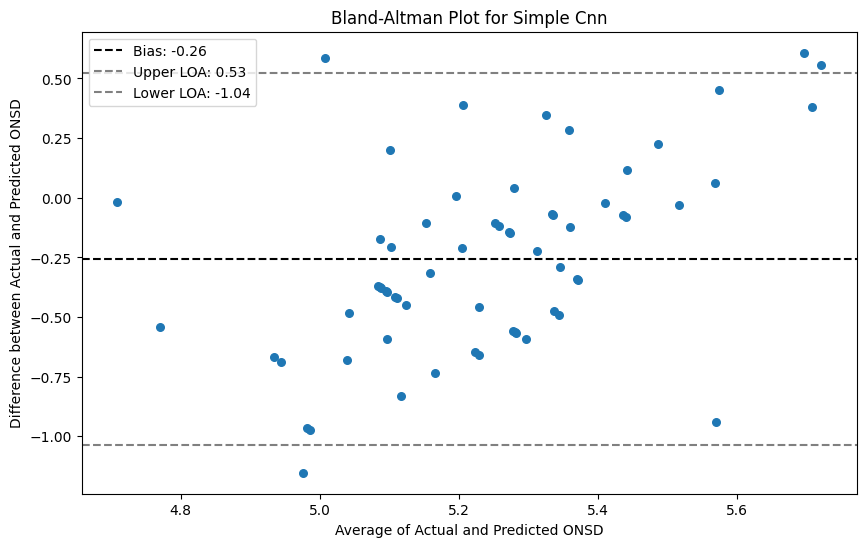

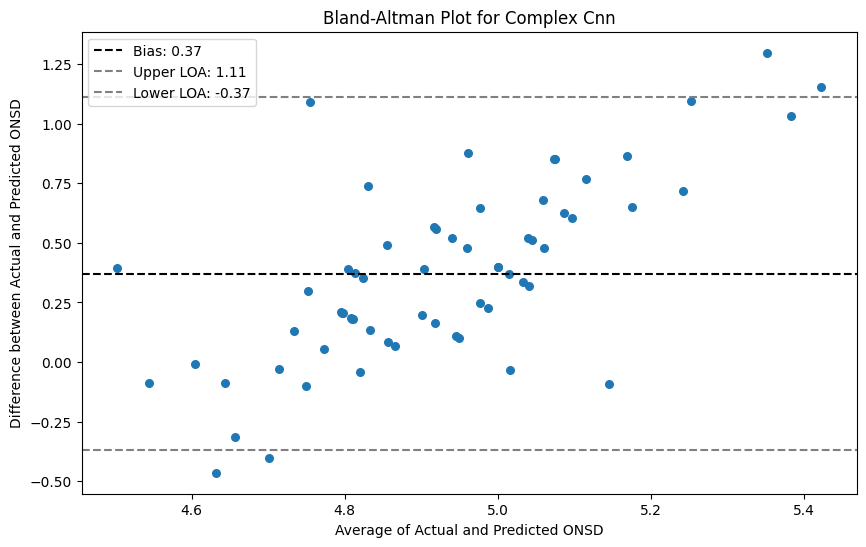

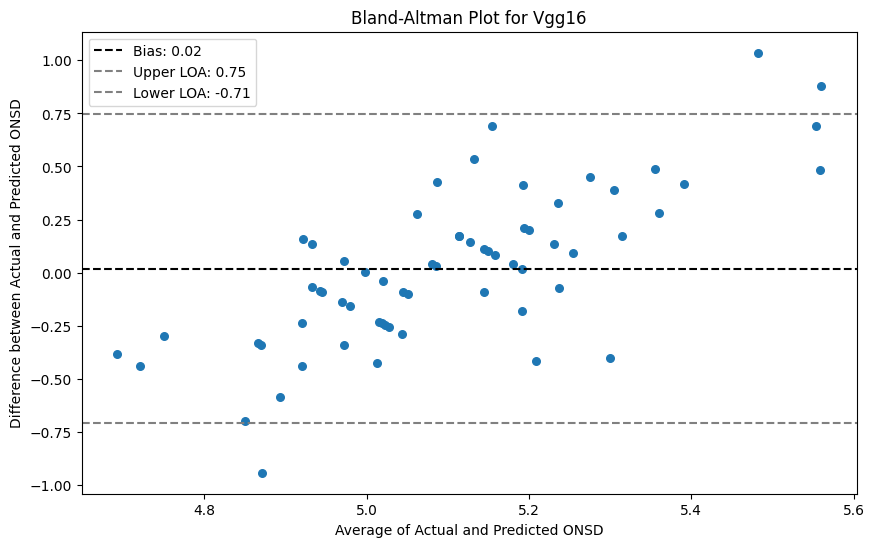

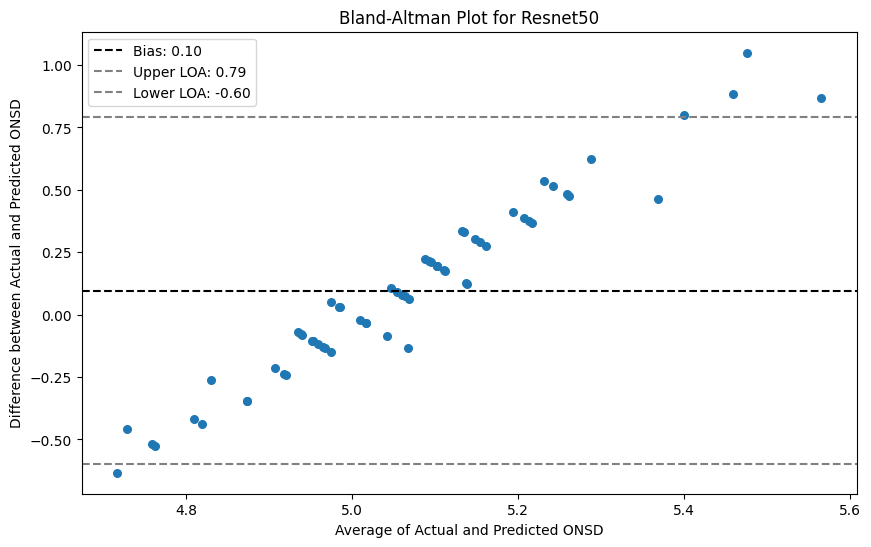

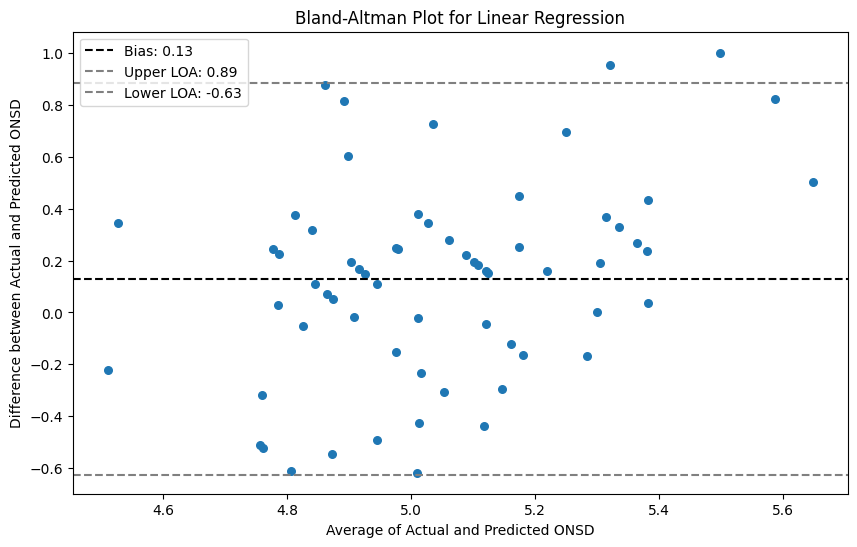

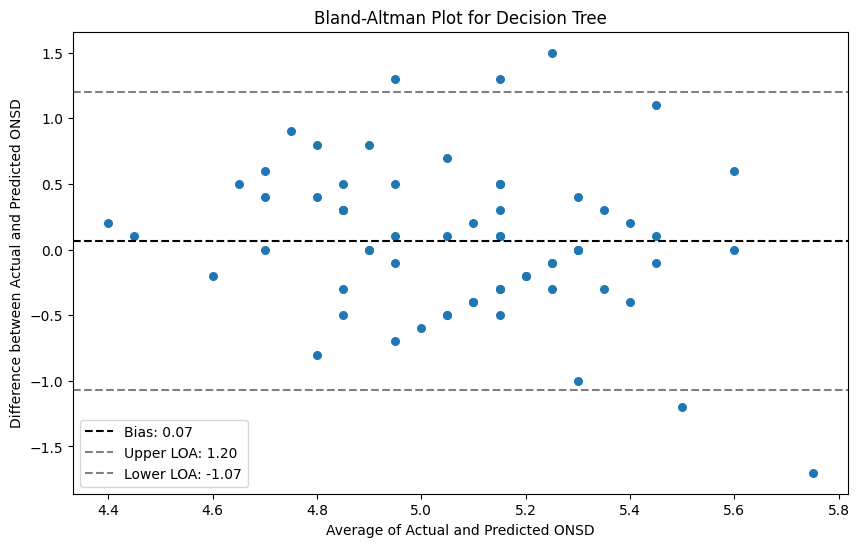

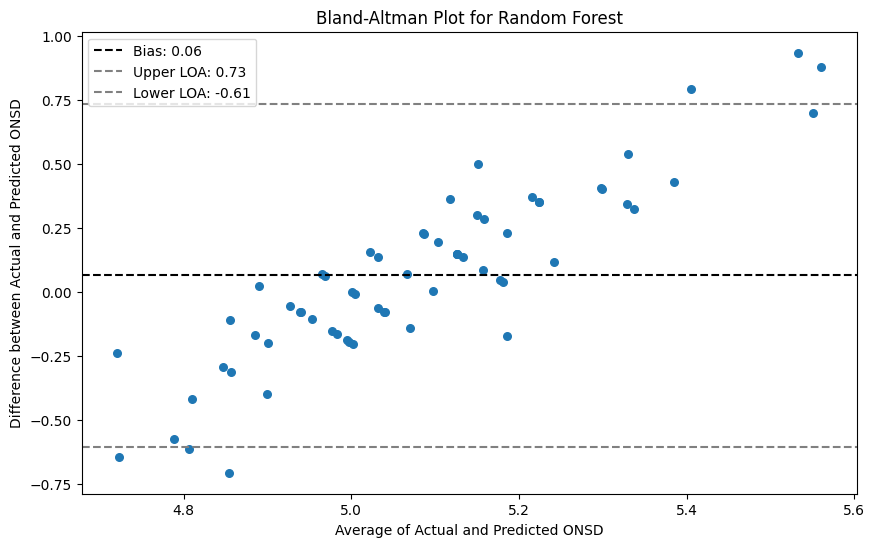

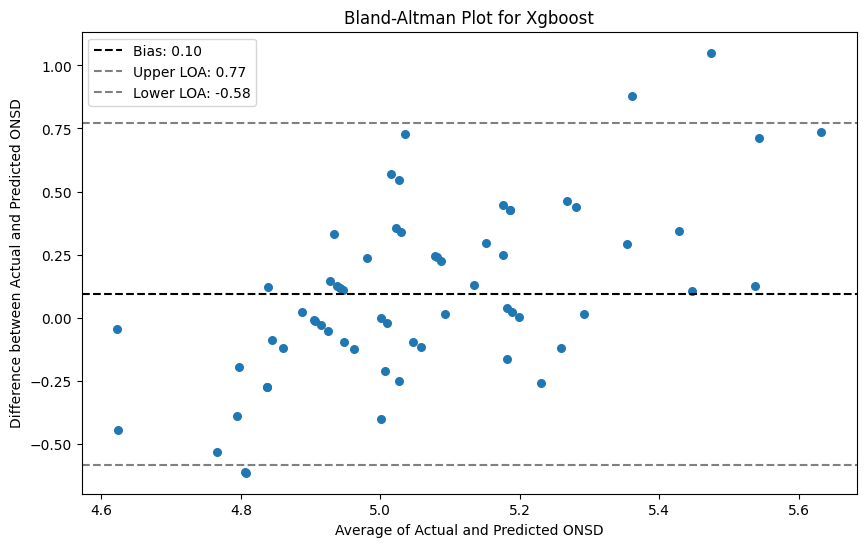

In [26]:
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load predictions from CSV
predictions_df = pd.read_csv('model_predictions.csv')

# Prepare the DataFrame for ICC calculation
icc_data = predictions_df.melt(id_vars=['y_test'], var_name='Model', value_name='Prediction')

# Calculate ICC
icc_results = pg.intraclass_corr(data=icc_data, targets='y_test', raters='Model', ratings='Prediction', nan_policy='omit')

# Inspect the columns of icc_results
print("ICC Results Columns:", icc_results.columns)
print(icc_results)

# Extract ICC value for 'ICC2' type
icc2_value = icc_results.loc[icc_results['Type'] == 'ICC2', 'ICC'].values[0]

# Calculate MAE and RMSE
mae_values = {
    'Simple CNN': mean_absolute_error(predictions_df['y_test'], predictions_df['simple_cnn']),
    'Complex CNN': mean_absolute_error(predictions_df['y_test'], predictions_df['complex_cnn']),
    'VGG16': mean_absolute_error(predictions_df['y_test'], predictions_df['vgg16']),
    'ResNet50': mean_absolute_error(predictions_df['y_test'], predictions_df['resnet50']),
    'Linear Regression': mean_absolute_error(predictions_df['y_test'], predictions_df['linear_regression']),
    'Decision Tree': mean_absolute_error(predictions_df['y_test'], predictions_df['decision_tree']),
    'Random Forest': mean_absolute_error(predictions_df['y_test'], predictions_df['random_forest']),
    'XGBoost': mean_absolute_error(predictions_df['y_test'], predictions_df['xgboost'])
}

rmse_values = {
    'Simple CNN': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['simple_cnn'])),
    'Complex CNN': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['complex_cnn'])),
    'VGG16': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['vgg16'])),
    'ResNet50': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['resnet50'])),
    'Linear Regression': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['linear_regression'])),
    'Decision Tree': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['decision_tree'])),
    'Random Forest': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['random_forest'])),
    'XGBoost': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['xgboost']))
}

# Comparison DataFrame
comparison_data = {
    'Model': ['Simple CNN', 'Complex CNN', 'VGG16', 'ResNet50', 'Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'MAE': [mae_values[model] for model in mae_values],
    'RMSE': [rmse_values[model] for model in rmse_values],
    'ICC': [icc2_value] * 8  # Assigning the same ICC2 value to all models
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

# Save comparison results
comparison_df.to_csv('model_comparison_with_metrics_and_icc.csv', index=False)

# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Model'], comparison_df['MAE'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Model Comparison - Mean Absolute Error')
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Model'], comparison_df['RMSE'], color='lightcoral')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Model Comparison - Root Mean Square Error')
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Model'], comparison_df['ICC'], color='lightgreen')
plt.xlabel('Model')
plt.ylabel('ICC')
plt.title('Model Comparison - Intraclass Correlation Coefficient')
plt.show()

# Bland-Altman Plots
def bland_altman_plot(actual, predicted, model_name):
    bland_altman_df = pd.DataFrame({
        'Actual ONSD': actual,
        'Predicted ONSD': predicted
    })

    bland_altman_df['Difference'] = bland_altman_df['Actual ONSD'] - bland_altman_df['Predicted ONSD']
    bland_altman_df['Average'] = (bland_altman_df['Actual ONSD'] + bland_altman_df['Predicted ONSD']) / 2

    bias = bland_altman_df['Difference'].mean()
    std_dev = bland_altman_df['Difference'].std()
    upper_loa = bias + 1.96 * std_dev
    lower_loa = bias - 1.96 * std_dev

    plt.figure(figsize=(10, 6))
    plt.scatter(bland_altman_df['Average'], bland_altman_df['Difference'], s=30)
    plt.axhline(bias, color='black', linestyle='--', label=f'Bias: {bias:.2f}')
    plt.axhline(upper_loa, color='gray', linestyle='--', label=f'Upper LOA: {upper_loa:.2f}')
    plt.axhline(lower_loa, color='gray', linestyle='--', label=f'Lower LOA: {lower_loa:.2f}')
    plt.xlabel('Average of Actual and Predicted ONSD')
    plt.ylabel('Difference between Actual and Predicted ONSD')
    plt.title(f'Bland-Altman Plot for {model_name}')
    plt.legend()
    plt.savefig(f'bland_altman_plot_{model_name}.png')
    plt.show()

# Create Bland-Altman plots for each model
for model in ['simple_cnn', 'complex_cnn', 'vgg16', 'resnet50', 'linear_regression', 'decision_tree', 'random_forest', 'xgboost']:
    bland_altman_plot(predictions_df['y_test'].values, predictions_df[model].values, model.replace('_', ' ').title())


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/pingouin/reliability.py:307: RuntimeWarning: invalid value encountered in scalar divide
  msw = (aov.at[1, "SS"] + aov.at[2, "SS"]) / (aov.at[1, "DF"] + aov.at[2, "DF"])
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/pingouin/reliability.py:307: RuntimeWarning: invalid value encountered in scalar divide
  msw = (aov.at[1, "SS"] + aov.at[2, "SS"]) / (aov.at[1, "DF"] + aov.at[2, "DF"])
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/pingouin/reliability.py:307: RuntimeWarning: invalid value encountered in scalar divide
  msw = (aov.at[1, "SS"] + aov.at[2, "SS"]) / (aov.at[1, "DF"] + aov.at[2, "DF"])
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/pingouin/reliability.py:307: RuntimeWarning: invalid value encountered in scalar divide
  msw = (aov.at[1, "SS"] + aov.at[2, "SS"]) / (aov.at[1, "DF"] + aov.at[2, "DF"])
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/pingouin/reliability.py:3

               Model       MAE      RMSE  ICC
0         Simple CNN  0.389235  0.471298  NaN
1        Complex CNN  0.422309  0.526604  NaN
2              VGG16  0.289633  0.369289  NaN
3           ResNet50  0.283800  0.364334  NaN
4  Linear Regression  0.325181  0.404511  NaN
5      Decision Tree  0.432812  0.578387  NaN
6      Random Forest  0.265537  0.345056  NaN
7            XGBoost  0.269137  0.356396  NaN


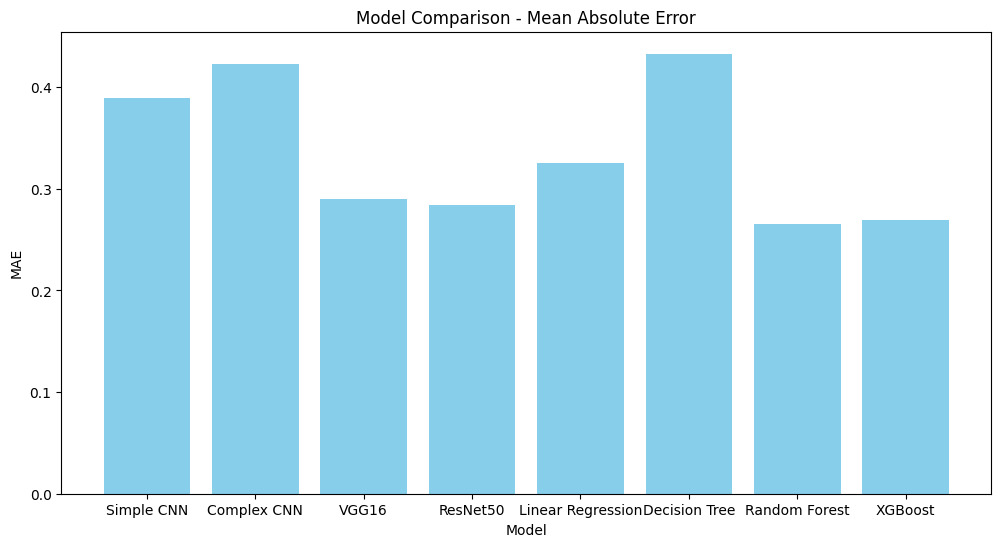

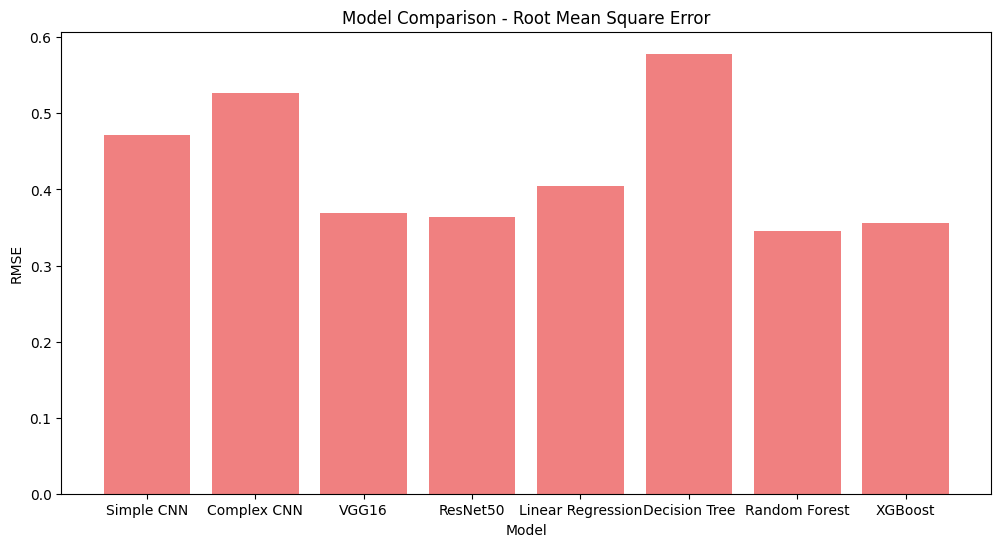

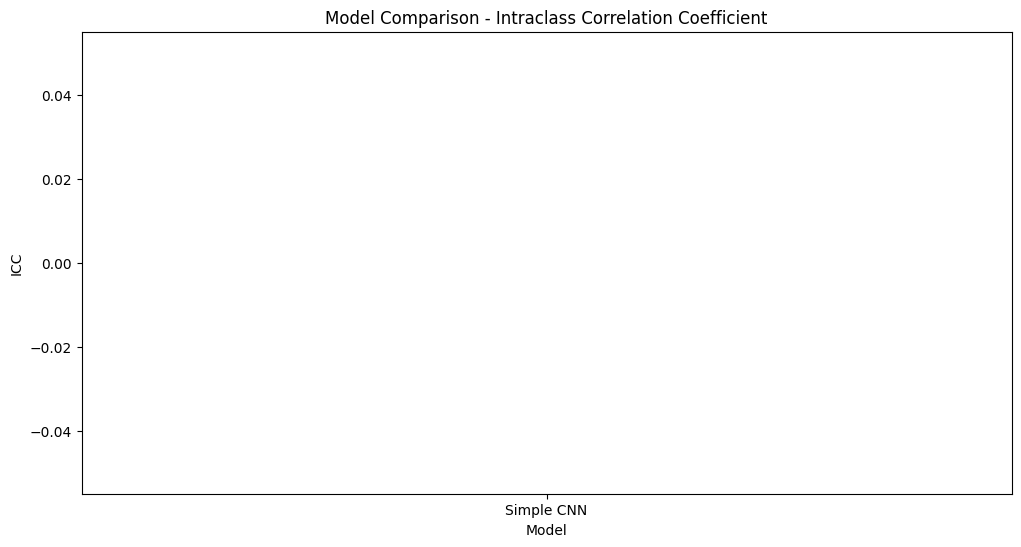

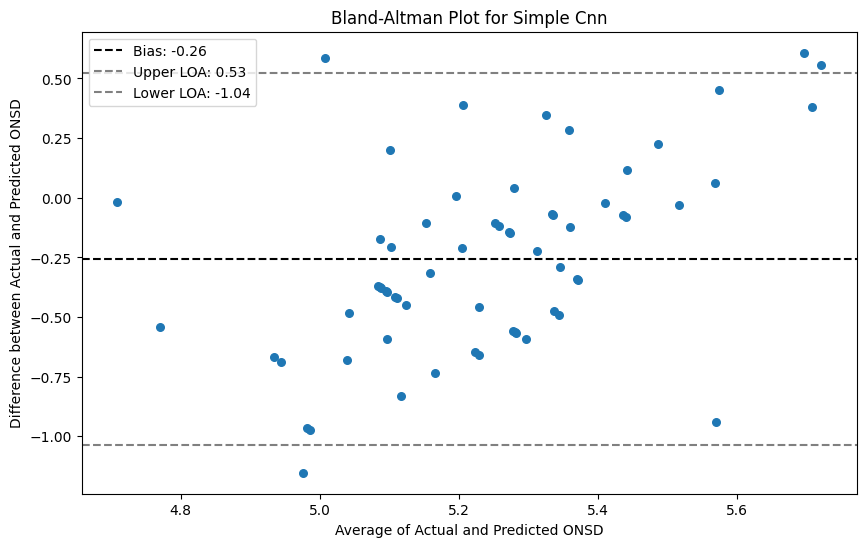

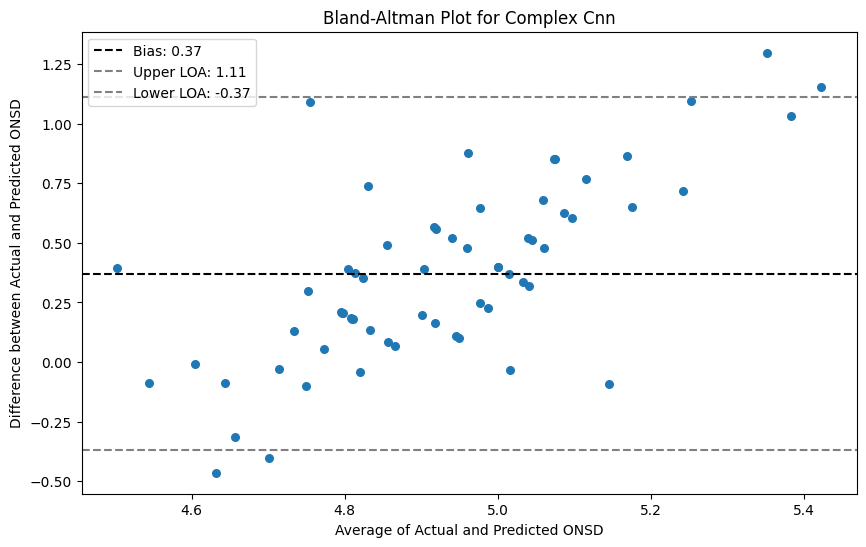

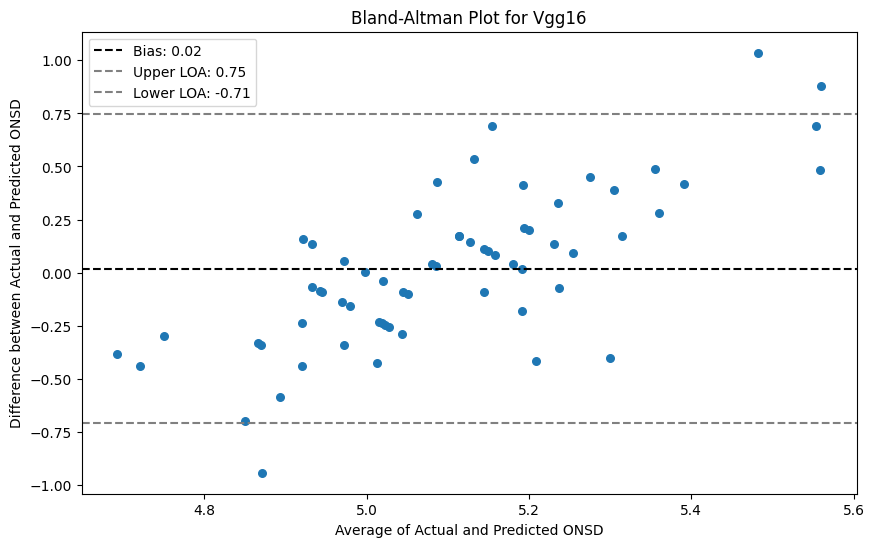

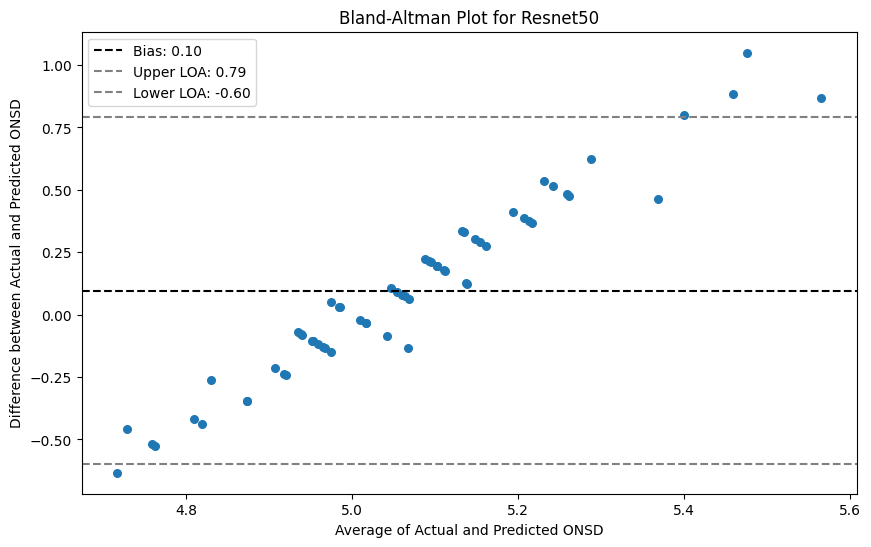

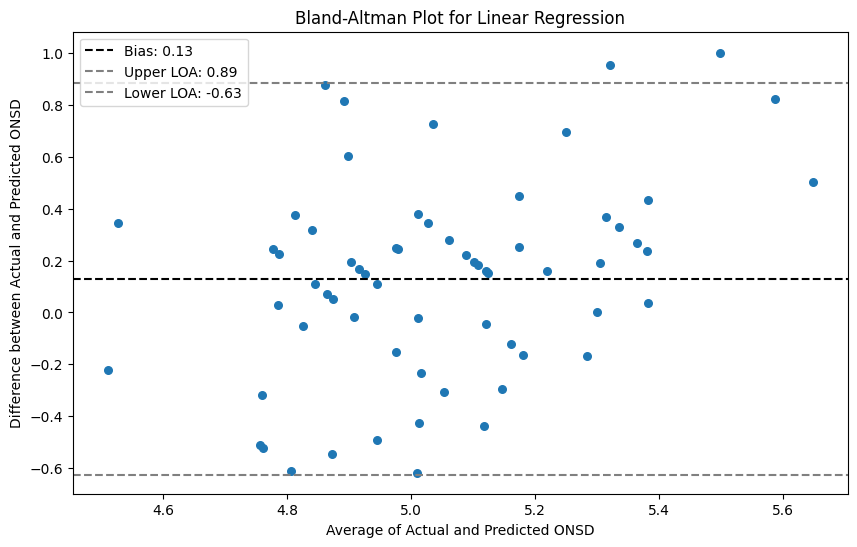

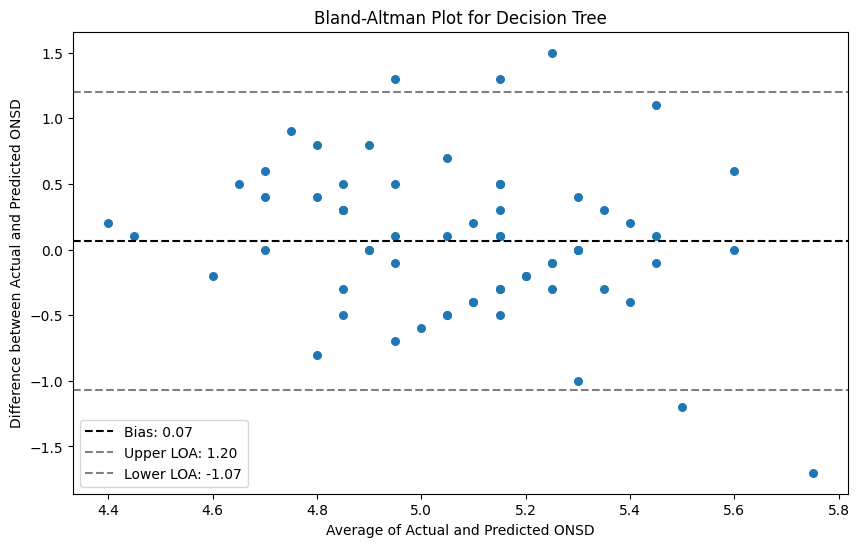

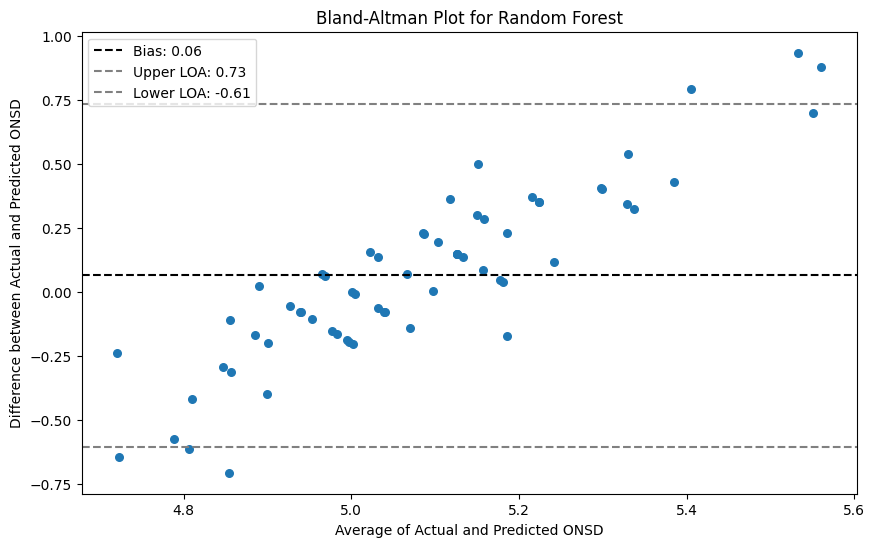

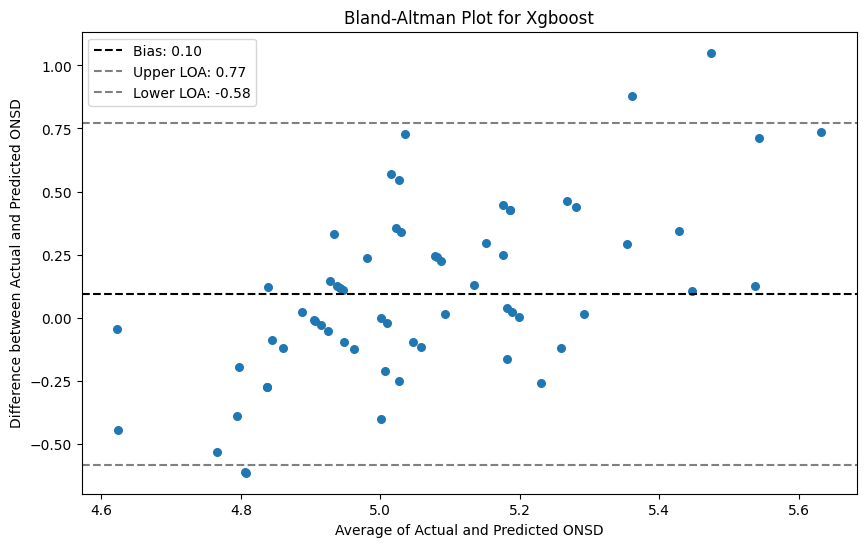

In [28]:
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load predictions from CSV
predictions_df = pd.read_csv('model_predictions.csv')

# Function to calculate ICC for a given model
def calculate_icc(actual, predicted):
    data = pd.DataFrame({
        'Actual': actual,
        'Predicted': predicted
    })
    melted_data = data.melt(id_vars='Actual', var_name='Rater', value_name='Value')
    icc = pg.intraclass_corr(data=melted_data, targets='Actual', raters='Rater', ratings='Value')
    return icc.loc[icc['Type'] == 'ICC2', 'ICC'].values[0]

# Calculate ICC for each model
icc_values = {
    'Simple CNN': calculate_icc(predictions_df['y_test'], predictions_df['simple_cnn']),
    'Complex CNN': calculate_icc(predictions_df['y_test'], predictions_df['complex_cnn']),
    'VGG16': calculate_icc(predictions_df['y_test'], predictions_df['vgg16']),
    'ResNet50': calculate_icc(predictions_df['y_test'], predictions_df['resnet50']),
    'Linear Regression': calculate_icc(predictions_df['y_test'], predictions_df['linear_regression']),
    'Decision Tree': calculate_icc(predictions_df['y_test'], predictions_df['decision_tree']),
    'Random Forest': calculate_icc(predictions_df['y_test'], predictions_df['random_forest']),
    'XGBoost': calculate_icc(predictions_df['y_test'], predictions_df['xgboost'])
}

# Calculate MAE and RMSE
mae_values = {
    'Simple CNN': mean_absolute_error(predictions_df['y_test'], predictions_df['simple_cnn']),
    'Complex CNN': mean_absolute_error(predictions_df['y_test'], predictions_df['complex_cnn']),
    'VGG16': mean_absolute_error(predictions_df['y_test'], predictions_df['vgg16']),
    'ResNet50': mean_absolute_error(predictions_df['y_test'], predictions_df['resnet50']),
    'Linear Regression': mean_absolute_error(predictions_df['y_test'], predictions_df['linear_regression']),
    'Decision Tree': mean_absolute_error(predictions_df['y_test'], predictions_df['decision_tree']),
    'Random Forest': mean_absolute_error(predictions_df['y_test'], predictions_df['random_forest']),
    'XGBoost': mean_absolute_error(predictions_df['y_test'], predictions_df['xgboost'])
}

rmse_values = {
    'Simple CNN': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['simple_cnn'])),
    'Complex CNN': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['complex_cnn'])),
    'VGG16': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['vgg16'])),
    'ResNet50': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['resnet50'])),
    'Linear Regression': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['linear_regression'])),
    'Decision Tree': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['decision_tree'])),
    'Random Forest': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['random_forest'])),
    'XGBoost': np.sqrt(mean_squared_error(predictions_df['y_test'], predictions_df['xgboost']))
}

# Comparison DataFrame
comparison_data = {
    'Model': list(mae_values.keys()),
    'MAE': list(mae_values.values()),
    'RMSE': list(rmse_values.values()),
    'ICC': list(icc_values.values())
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

# Save comparison results
comparison_df.to_csv('model_comparison_with_metrics_and_icc.csv', index=False)

# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Model'], comparison_df['MAE'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Model Comparison - Mean Absolute Error')
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Model'], comparison_df['RMSE'], color='lightcoral')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Model Comparison - Root Mean Square Error')
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Model'], comparison_df['ICC'], color='lightgreen')
plt.xlabel('Model')
plt.ylabel('ICC')
plt.title('Model Comparison - Intraclass Correlation Coefficient')
plt.show()

# Bland-Altman Plots
def bland_altman_plot(actual, predicted, model_name):
    bland_altman_df = pd.DataFrame({
        'Actual ONSD': actual,
        'Predicted ONSD': predicted
    })

    bland_altman_df['Difference'] = bland_altman_df['Actual ONSD'] - bland_altman_df['Predicted ONSD']
    bland_altman_df['Average'] = (bland_altman_df['Actual ONSD'] + bland_altman_df['Predicted ONSD']) / 2

    bias = bland_altman_df['Difference'].mean()
    std_dev = bland_altman_df['Difference'].std()
    upper_loa = bias + 1.96 * std_dev
    lower_loa = bias - 1.96 * std_dev

    plt.figure(figsize=(10, 6))
    plt.scatter(bland_altman_df['Average'], bland_altman_df['Difference'], s=30)
    plt.axhline(bias, color='black', linestyle='--', label=f'Bias: {bias:.2f}')
    plt.axhline(upper_loa, color='gray', linestyle='--', label=f'Upper LOA: {upper_loa:.2f}')
    plt.axhline(lower_loa, color='gray', linestyle='--', label=f'Lower LOA: {lower_loa:.2f}')
    plt.xlabel('Average of Actual and Predicted ONSD')
    plt.ylabel('Difference between Actual and Predicted ONSD')
    plt.title(f'Bland-Altman Plot for {model_name}')
    plt.legend()
    plt.savefig(f'bland_altman_plot_{model_name}.png')
    plt.show()

# Create Bland-Altman plots for each model
for model in ['simple_cnn', 'complex_cnn', 'vgg16', 'resnet50', 'linear_regression', 'decision_tree', 'random_forest', 'xgboost']:
    bland_altman_plot(predictions_df['y_test'].values, predictions_df[model].values, model.replace('_', ' ').title())
